# Final Project - Socioeconomic Status & Education

## Set Up

### Imports and data

In [1]:
import pyreadstat
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, skew, kurtosis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from scipy.stats import f_oneway

In [ ]:
hsls_school, meta = pyreadstat.read_sav('../Data/HSLS_2017_PETS_SR_v1_0_SPSS_Datasets/hsls_17_student_pets_sr_v1_0.sav')

In [3]:
print(f'Number of columns {hsls_school.shape[1]}')

Number of columns 9614


We will need to limit the variables a bit as there are far too many to handle effectively

In [4]:
# Filter for relevant
relevantVars = [ 
    'STU_ID',
    'X1SES',
    'X1SESQ5',
    'X1FAMINCOME', 
    'X1PAREDU',
    'X1PAR1EMP',
    'X1TXMTH',
    'X3TGPAACAD',
    'X3EVERDROP',
    'X1SEX',
    'X1RACE',
    'X1POVERTY',
    'X1LOCALE',
    #'X1REGION',
    #'X1CONTROL',
    'X1SCHOOLBEL',
    'X1SCHOOLENG'
    ]

hsls_school_relevant = hsls_school[relevantVars]

# Explain meanings
for var in relevantVars:
    print(var, ':\n', meta.column_names_to_labels[var])
    if var in meta.variable_value_labels:
        print(' Value Meaning:', meta.variable_value_labels[var])

STU_ID :
 Student ID
X1SES :
 X1 Socio-economic status composite
X1SESQ5 :
 X1 Quintile coding of X1SES composite
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 1.0: 'First quintile (lowest)', 2.0: 'Second quintile', 3.0: 'Third quintile', 4.0: 'Fourth quintile', 5.0: 'Fifth quintile (highest)'}
X1FAMINCOME :
 X1 Total family income from all sources 2008
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 1.0: 'Family income less than or equal to $15,000', 2.0: 'Family income > $15,000 and <= $35,000', 3.0: 'Family income > $35,000 and <= $55,000', 4.0: 'Family income > $55,000 and <= $75,000', 5.0: 'Family income > $75,000 and <= $95,000', 6.0: 'Family income > $95,000 and <= $115,000', 7.0: 'Family income > $115,000 and <= $135,000', 8.0: 'Family income > $135,000 and <= $155,000', 9.0: 'Family income > $155,000 and <=$175,000', 10.0: 'Family income > $175,000 and <= $195,000', 11.0: 'Family inco

In [5]:
hsls_school_relevant.head()  # Display the DataFrame information to check the structure and data types

,STU_ID,X1SES,X1SESQ5,X1FAMINCOME,X1PAREDU,X1PAR1EMP,X1TXMTH,X3TGPAACAD,X3EVERDROP,X1SEX,X1RACE,X1POVERTY,X1LOCALE,X1SCHOOLBEL,X1SCHOOLENG
0,10001,1.5644,5.0,10.0,5.0,4.0,0.8304,3.5,0.0,1.0,8.0,0.0,4.0,0.84,-1.41
1,10002,-0.3699,2.0,3.0,3.0,3.0,-0.2956,4.0,0.0,2.0,8.0,0.0,4.0,0.05,-0.20
2,10003,1.2741,5.0,6.0,7.0,4.0,1.2997,2.5,0.0,2.0,3.0,0.0,2.0,0.37,1.39
3,10004,0.5498,5.0,5.0,4.0,2.0,-0.1427,4.0,0.0,2.0,8.0,0.0,2.0,-0.04,-0.20
4,10005,0.1495,4.0,9.0,4.0,4.0,1.1405,3.5,1.0,1.0,8.0,0.0,1.0,-2.27,0.33


### Functions

-9 is the only true missing data in the dataset, the other "missing values" are choices to not participate or people the survey was not given to

In [6]:
# Function to make -9 null for data cleaning
def specifyMissingness(value):
    return np.nan if value == -9 else value

In [7]:
def generate_correlations_pvalues(df, vars=None):
    if not vars: 
        df = df.select_dtypes(include=[np.number])
        vars = df.columns
    corr_table = pd.DataFrame(index=vars, columns=vars)
    p_value_table = pd.DataFrame(index=vars, columns=vars)
    for i in vars:
        for j in vars:
            if vars.tolist().index(i) < vars.tolist().index(j):
                corr_table.loc[i, j] = ''
                p_value_table.loc[i, j] = ''
            else:
                corr, p_value = pearsonr(df[i], df[j])
                corr_table.loc[i, j] = '-' if i == j else f'{corr:.3f}*' if p_value < 0.05 else f'{corr:.3f}'
                p_value_table.loc[i, j] = '-' if i == j else f'{p_value:.4f}'
    return corr_table, p_value_table

In [8]:
def remove_outliers(df, cols=None, threshold=1.5):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()

    mask = pd.Series(True, index=df.index)

    for col in cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - threshold * iqr
        upper = q3 + threshold * iqr
        mask &= df[col].between(lower, upper)

    return df[mask].reset_index(drop=True)

In [9]:
def ANOVA_On_Cluster(data, cluster_Vars, num_clusters, cluster_Col = 'Cluster'):
    # Initialize results dictionary for ANOVA
    anova_results = {
        "Variable": [],
        "Cluster Mean Square": [],
        "Cluster df": [],
        "Error Mean Square": [],
        "Error df": [],
        "F": [],
        "P_Val": []
    }
    # Perform ANOVA for each variable
    for variable in cluster_Vars:
        # Group data by cluster
        groups = [data[data[cluster_Col] == cluster][variable] for cluster in range(0, num_clusters)]
        # Perform ANOVA
        f_stat, p_value = f_oneway(*groups)

        # Calculate degrees of freedom
        cluster_df = num_clusters - 1
        error_df = len(data) - num_clusters

        # Calculate Cluster Mean Square
        overall_mean = data[variable].mean()
        cluster_mean_square = (
            sum([(len(group) * (group.mean() - overall_mean) ** 2) for group in groups])
            / cluster_df
        )

        # Calculate Error Mean Square
        error_mean_square = (
            sum([((group - group.mean()) ** 2).sum() for group in groups]) / error_df
        )

        # Append results
        anova_results["Variable"].append(variable)
        anova_results["Cluster Mean Square"].append(cluster_mean_square)
        anova_results["Cluster df"].append(cluster_df)
        anova_results["Error Mean Square"].append(error_mean_square)
        anova_results["Error df"].append(error_df)
        anova_results["F"].append(f_stat)
        anova_results["P_Val"].append(p_value)

    # Return results to a DataFrame
    return pd.DataFrame(anova_results)

## Data Cleaning

In [10]:
# Get a copy of the relevant data that we will clean
hsls_school_relevant_clean = hsls_school_relevant.copy()

# Define my categorical and continuous variables 
## Important since categorical variables are encoded with floats
continous_vars = ['X1SES', 'X1TXMTH', 'X3TGPAACAD', 'X1SCHOOLBEL', 'X1SCHOOLENG']
categorical_vars = [var for var in hsls_school_relevant_clean.columns if var not in continous_vars]

# Display info of the dataset including variable encoding information
print(hsls_school_relevant_clean.info())

for var in hsls_school_relevant_clean.columns:
    print(var, ':\n', meta.column_names_to_labels[var])
    if var in meta.variable_value_labels:
        print(' Value Meaning:', meta.variable_value_labels[var])
    display(hsls_school_relevant_clean[var].value_counts().sort_index().reset_index())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23503 entries, 0 to 23502
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   STU_ID       23503 non-null  object 
 1   X1SES        23503 non-null  float64
 2   X1SESQ5      23503 non-null  float64
 3   X1FAMINCOME  23503 non-null  float64
 4   X1PAREDU     23503 non-null  float64
 5   X1PAR1EMP    23503 non-null  float64
 6   X1TXMTH      23503 non-null  float64
 7   X3TGPAACAD   23503 non-null  float64
 8   X3EVERDROP   23503 non-null  float64
 9   X1SEX        23503 non-null  float64
 10  X1RACE       23503 non-null  float64
 11  X1POVERTY    23503 non-null  float64
 12  X1LOCALE     23503 non-null  float64
 13  X1SCHOOLBEL  23503 non-null  float64
 14  X1SCHOOLENG  23503 non-null  float64
dtypes: float64(14), object(1)
memory usage: 2.7+ MB
None
STU_ID :
 Student ID


,STU_ID,count
0,10001,1
1,10002,1
2,10003,1
3,10004,1
4,10005,1
...,...,...
23498,35202,1
23499,35203,1
23500,35204,1
23501,35205,1


X1SES :
 X1 Socio-economic status composite


,X1SES,count
0,-8.0000,2059
1,-1.9302,1
2,-1.8153,1
3,-1.7526,19
4,-1.7315,1
...,...,...
9702,2.5372,2
9703,2.5466,5
9704,2.5574,1
9705,2.5668,30


X1SESQ5 :
 X1 Quintile coding of X1SES composite
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 1.0: 'First quintile (lowest)', 2.0: 'Second quintile', 3.0: 'Third quintile', 4.0: 'Fourth quintile', 5.0: 'Fifth quintile (highest)'}


,X1SESQ5,count
0,-8.0,2059
1,1.0,3434
2,2.0,3705
3,3.0,4233
4,4.0,4553
5,5.0,5519


X1FAMINCOME :
 X1 Total family income from all sources 2008
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 1.0: 'Family income less than or equal to $15,000', 2.0: 'Family income > $15,000 and <= $35,000', 3.0: 'Family income > $35,000 and <= $55,000', 4.0: 'Family income > $55,000 and <= $75,000', 5.0: 'Family income > $75,000 and <= $95,000', 6.0: 'Family income > $95,000 and <= $115,000', 7.0: 'Family income > $115,000 and <= $135,000', 8.0: 'Family income > $135,000 and <= $155,000', 9.0: 'Family income > $155,000 and <=$175,000', 10.0: 'Family income > $175,000 and <= $195,000', 11.0: 'Family income > $195,000 and <= $215,000', 12.0: 'Family income > $215,000 and <= $235,000', 13.0: 'Family income > $235,000'}


,X1FAMINCOME,count
0,-9.0,27
1,-8.0,6715
2,1.0,1570
3,2.0,3043
4,3.0,2762
5,4.0,2514
6,5.0,1855
7,6.0,1484
8,7.0,964
9,8.0,741


X1PAREDU :
 X1 Parents'/guardians' highest level of education
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 0.0: 'No bio/adoptive/step-parent in household', 1.0: 'Less than high school', 2.0: 'High school diploma or GED', 3.0: "Associate's degree", 4.0: "Bachelor's degree", 5.0: "Master's degree", 7.0: 'Ph.D/M.D/Law/other high lvl prof degree'}


,X1PAREDU,count
0,-9.0,6
1,-8.0,6715
2,1.0,1010
3,2.0,5909
4,3.0,2549
5,4.0,4102
6,5.0,2116
7,7.0,1096


X1PAR1EMP :
 X1 Parent 1: employment status
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 1.0: 'P1 has never worked for pay', 2.0: 'P1 not currently working for pay', 3.0: 'P1 currently working PT (<35 hrs/wk)', 4.0: 'P1 currently working FT (>=35 hrs/wk)'}


,X1PAR1EMP,count
0,-9.0,27
1,-8.0,6715
2,1.0,551
3,2.0,4142
4,3.0,2362
5,4.0,9706


X1TXMTH :
 X1 Mathematics theta score


,X1TXMTH,count
0,-8.0000,2059
1,-2.5751,1
2,-2.5696,1
3,-2.5672,1
4,-2.5464,1
...,...,...
15965,2.8764,2
15966,2.9097,1
15967,2.9228,1
15968,2.9319,1


X3TGPAACAD :
 X3 GPA for all academic courses


,X3TGPAACAD,count
0,-9.00,40
1,-8.00,1575
2,-1.00,30
3,0.25,205
4,0.50,562
5,1.00,1104
6,1.50,2304
7,2.00,3397
8,2.50,4091
9,3.00,4417


X3EVERDROP :
 X3 Ever dropout
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', -6.0: 'Component not applicable', -4.0: 'Item not administered: abbreviated interview', 0.0: 'No known dropout episode', 1.0: 'At least one known dropout episode'}


,X3EVERDROP,count
0,0.0,20927
1,1.0,2576


X1SEX :
 X1 Student's sex
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 1.0: 'Male', 2.0: 'Female'}


,X1SEX,count
0,-9.0,6
1,1.0,11973
2,2.0,11524


X1RACE :
 X1 Student's race/ethnicity-composite
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 0.0: 'No bio/adoptive/step-parent in household', 1.0: 'Amer. Indian/Alaska Native, non-Hispanic', 2.0: 'Asian, non-Hispanic', 3.0: 'Black/African-American, non-Hispanic', 4.0: 'Hispanic, no race specified', 5.0: 'Hispanic, race specified', 6.0: 'More than one race, non-Hispanic', 7.0: 'Native Hawaiian/Pacific Islander, non-Hispanic', 8.0: 'White, non-Hispanic'}


,X1RACE,count
0,-9.0,1006
1,1.0,165
2,2.0,1952
3,3.0,2450
4,4.0,422
5,5.0,3375
6,6.0,1941
7,7.0,110
8,8.0,12082


X1POVERTY :
 X1 Poverty indicator (relative to 100% of Census poverty threshold)
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 0.0: 'At or above poverty threshold', 1.0: 'Below poverty threshold'}


,X1POVERTY,count
0,-9.0,55
1,-8.0,6715
2,0.0,14062
3,1.0,2671


X1LOCALE :
 X1 School locale (urbanicity)
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 1.0: 'City', 2.0: 'Suburb', 3.0: 'Town', 4.0: 'Rural'}


,X1LOCALE,count
0,1.0,6689
1,2.0,8467
2,3.0,2788
3,4.0,5559


X1SCHOOLBEL :
 X1 Scale of student's sense of school belonging


,X1SCHOOLBEL,count
0,-9.00,764
1,-8.00,2059
2,-4.35,21
3,-4.10,1
4,-4.02,2
...,...,...
378,1.10,381
379,1.23,194
380,1.26,472
381,1.34,937


X1SCHOOLENG :
 X1 Scale of student's school engagement


,X1SCHOOLENG,count
0,-9.00,542
1,-8.00,2059
2,-3.38,74
3,-3.08,59
4,-3.00,23
...,...,...
190,0.90,176
191,0.96,312
192,1.01,1886
193,1.09,584


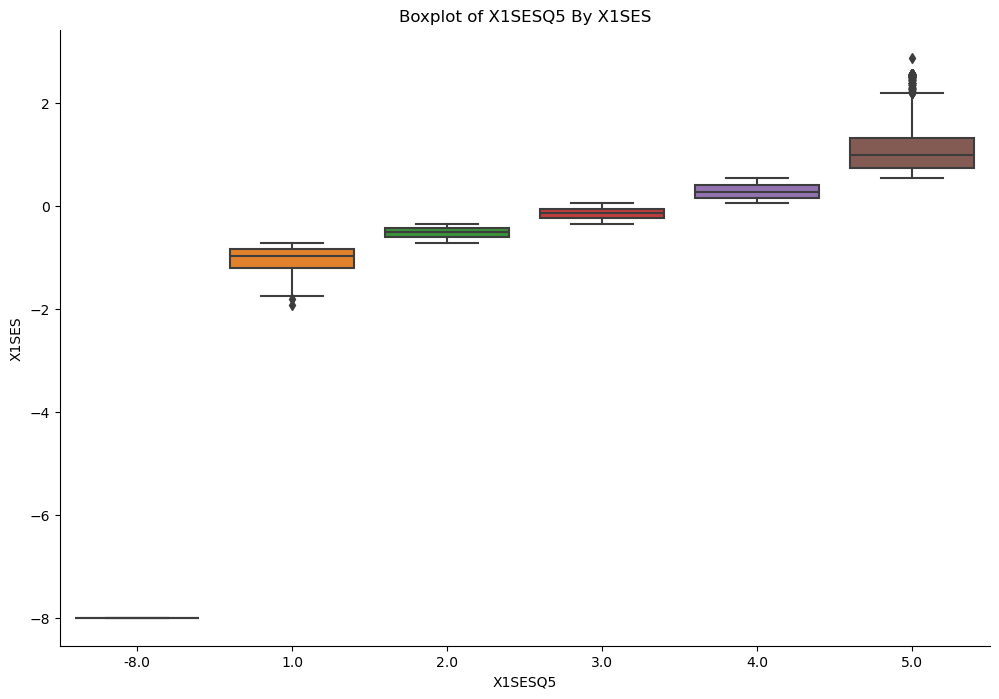

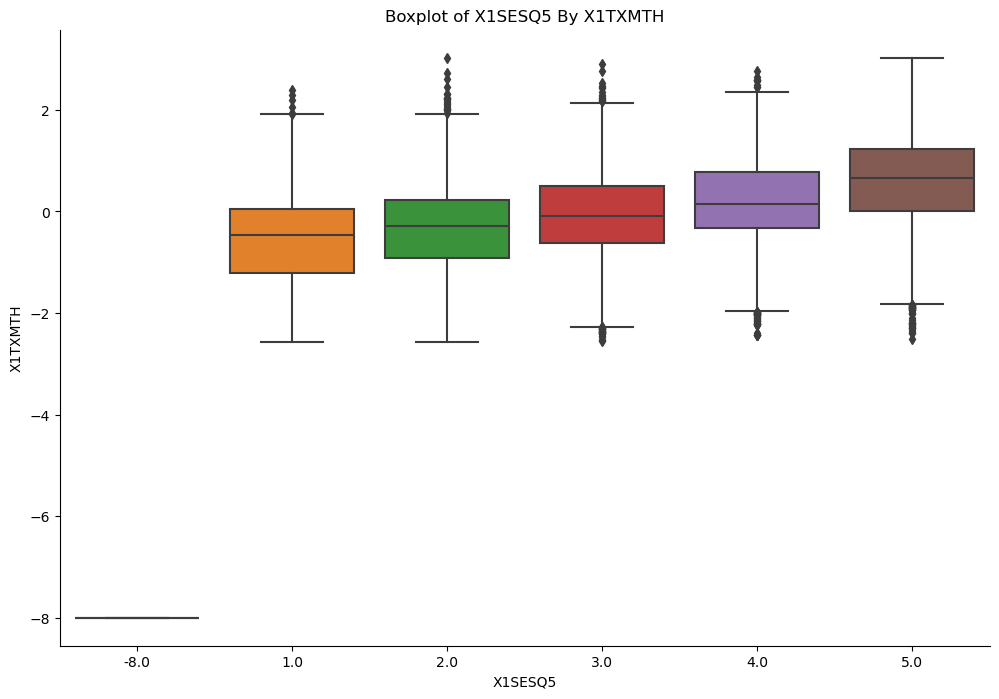

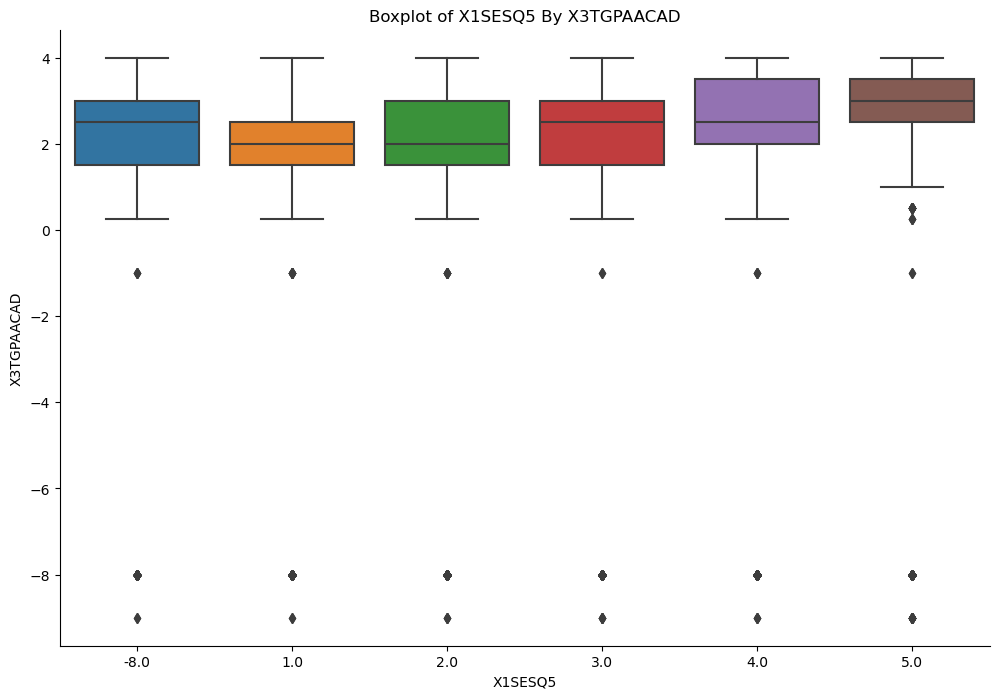

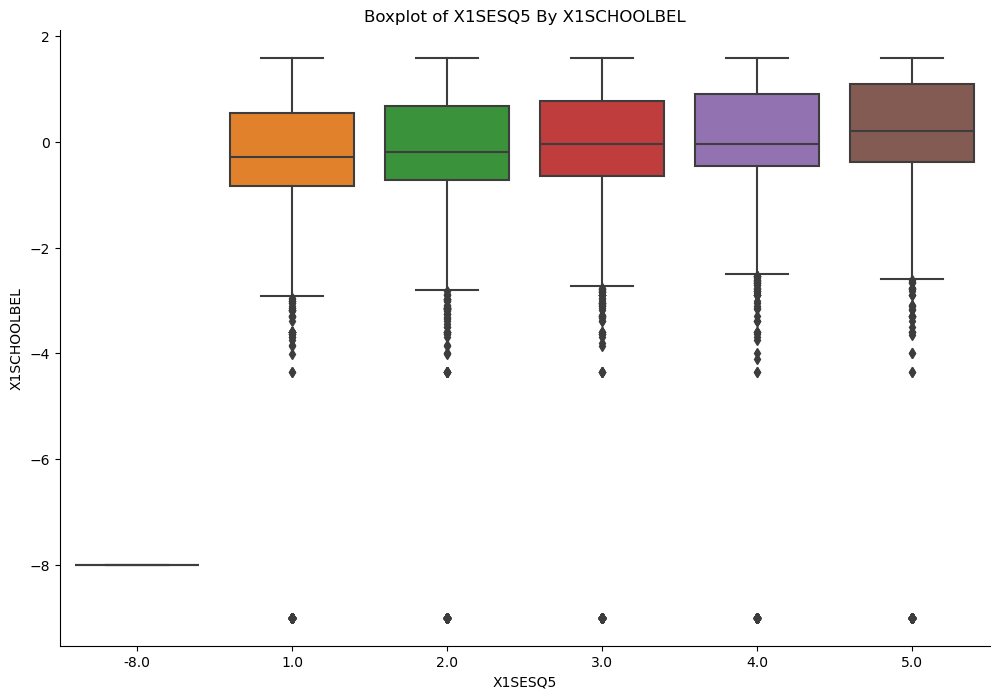

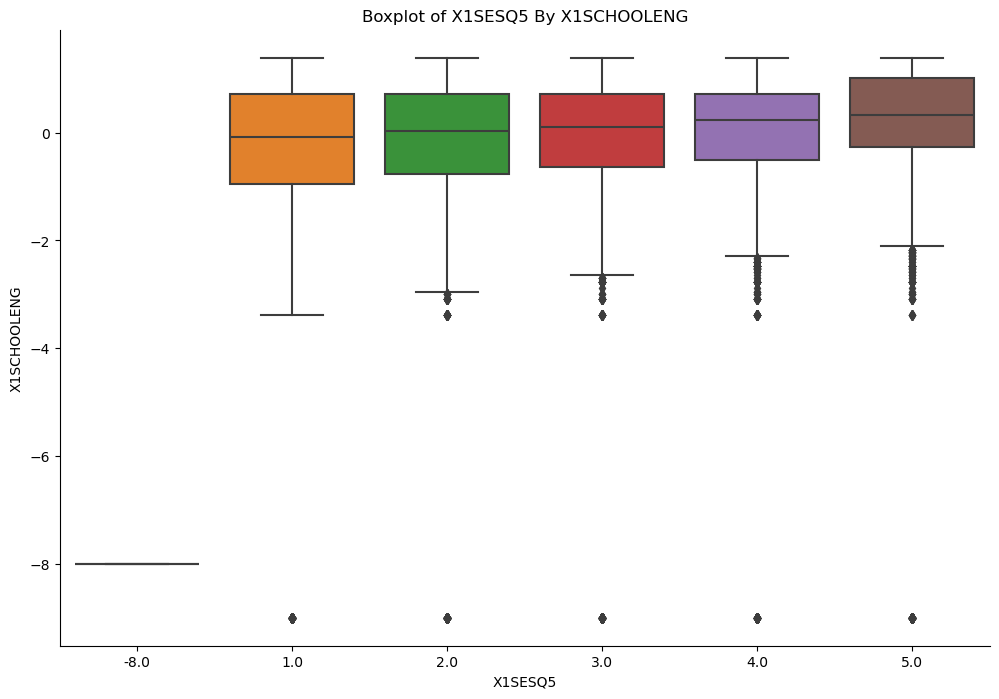

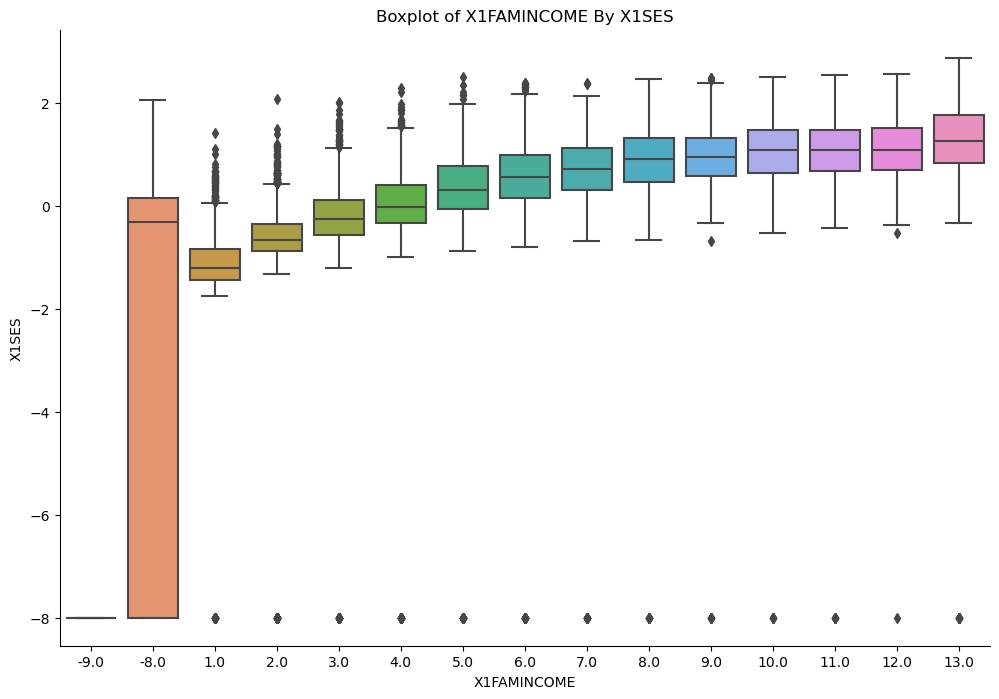

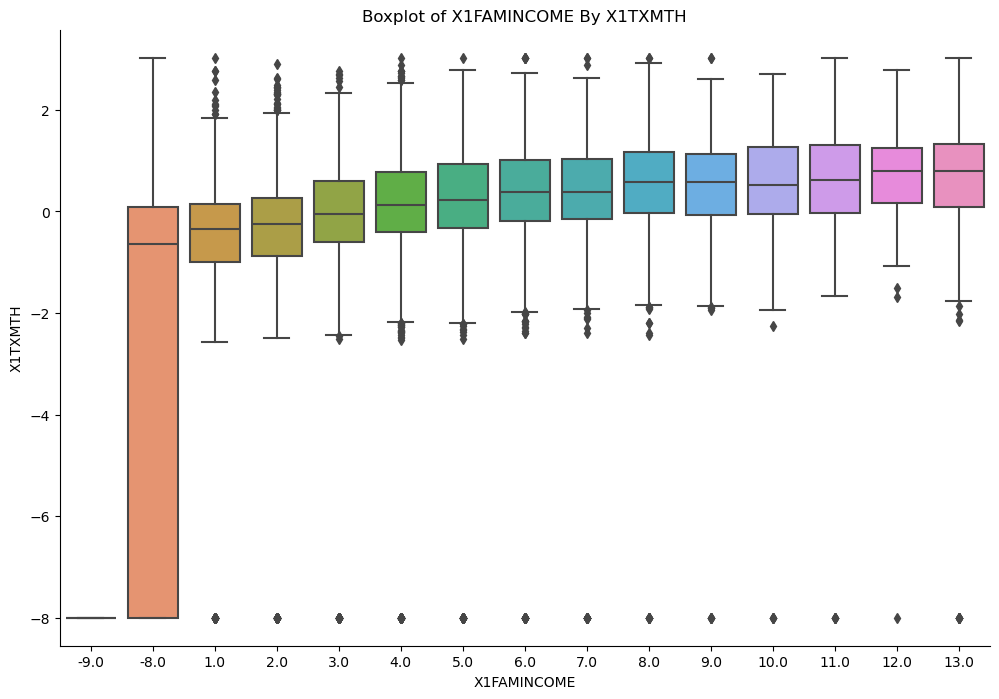

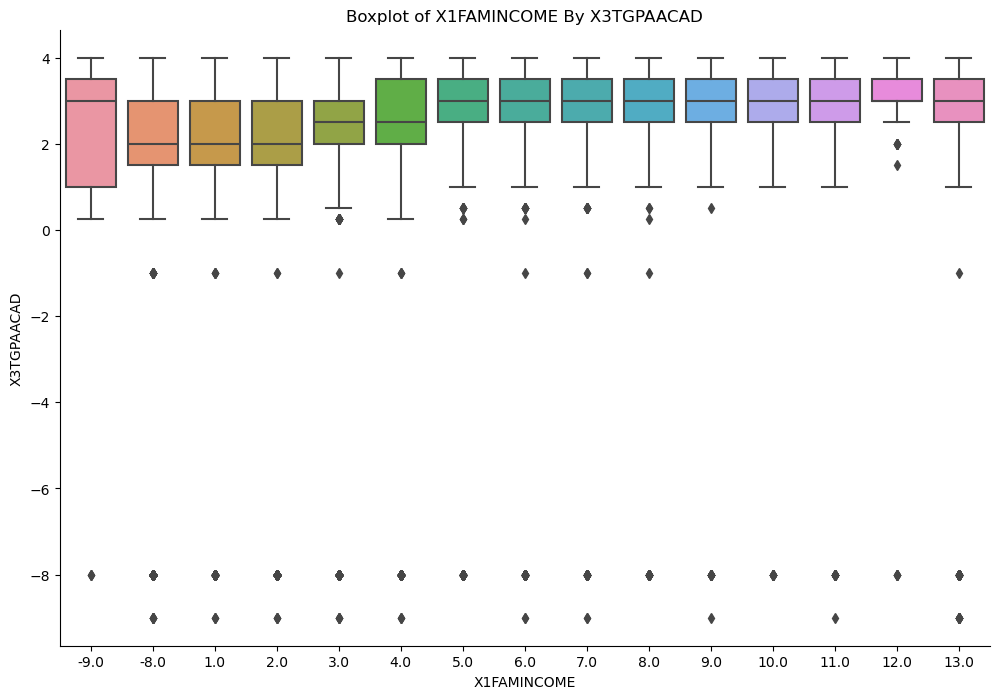

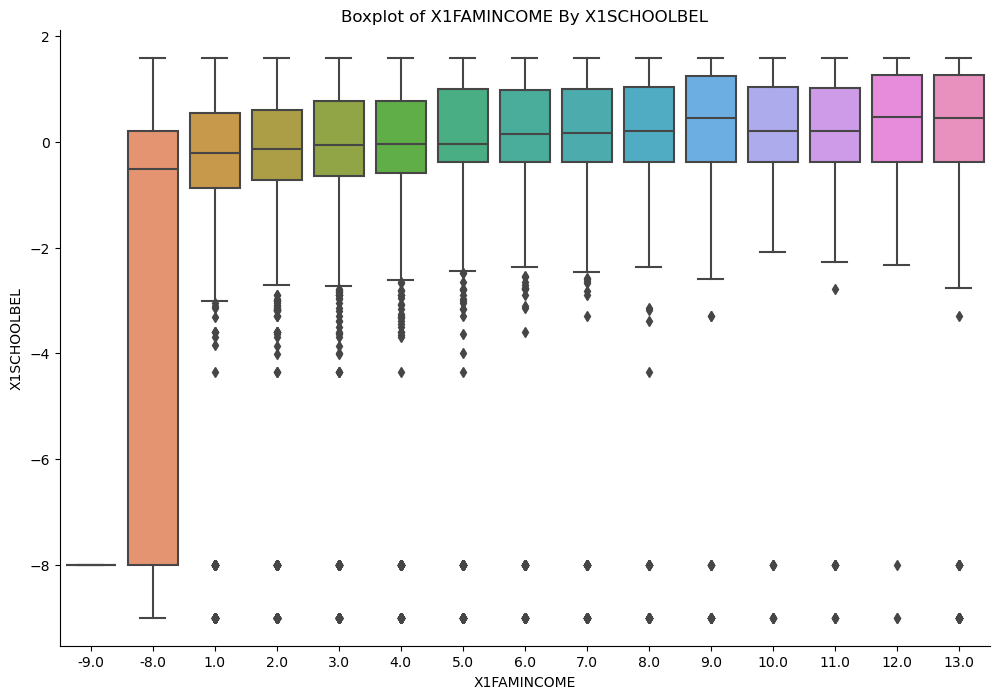

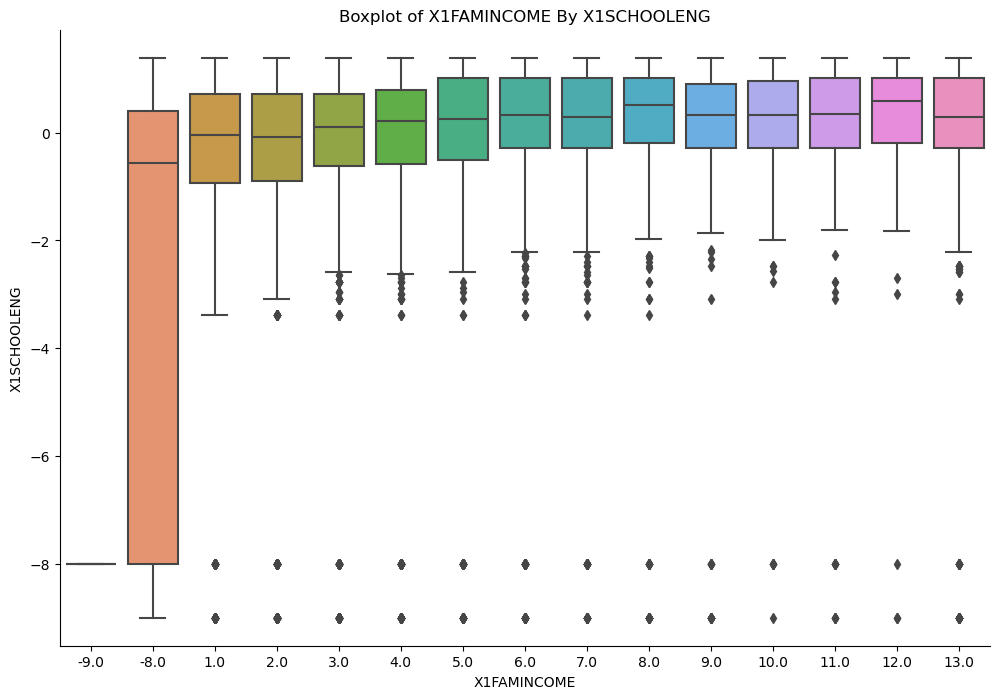

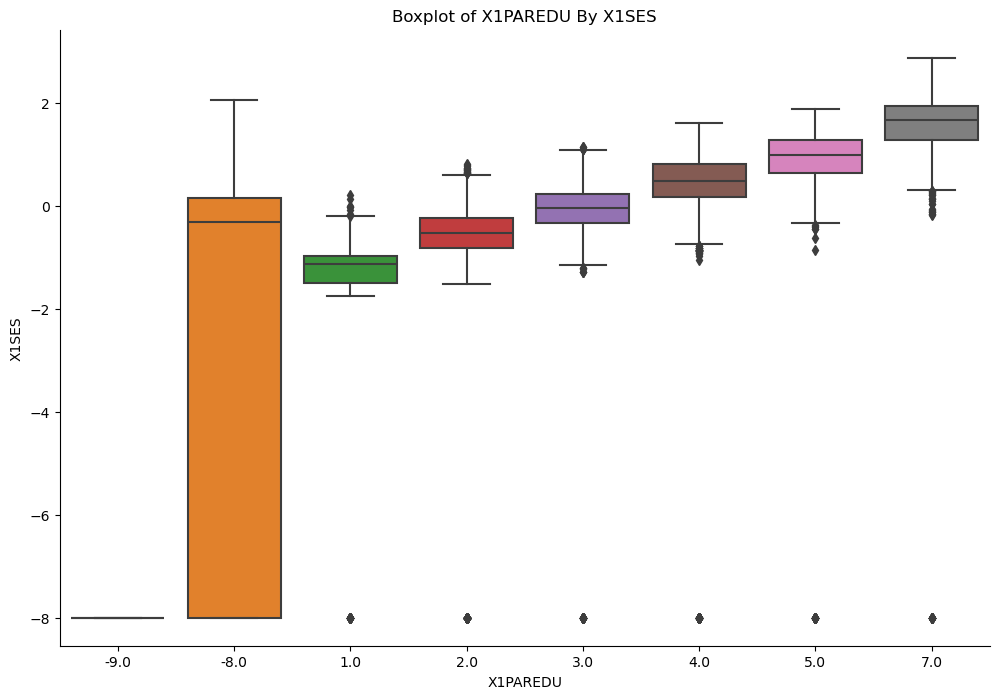

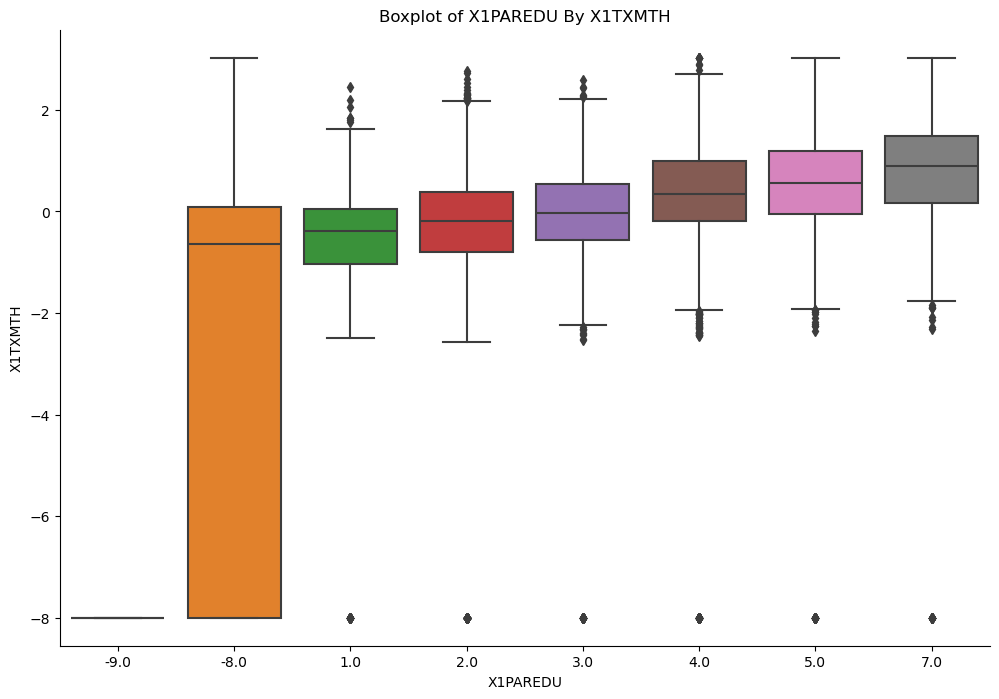

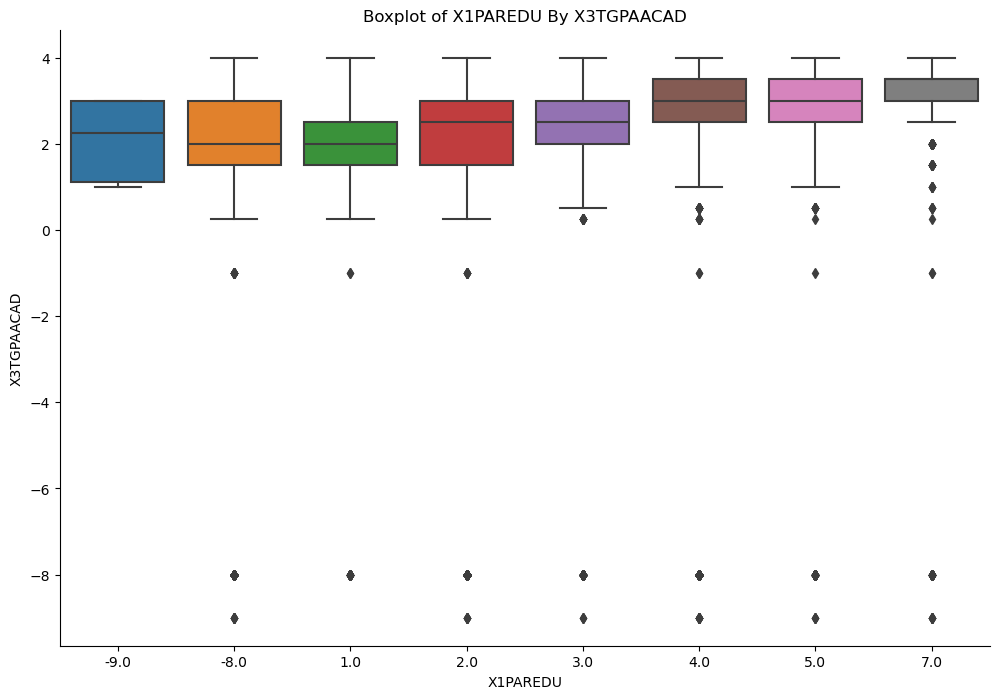

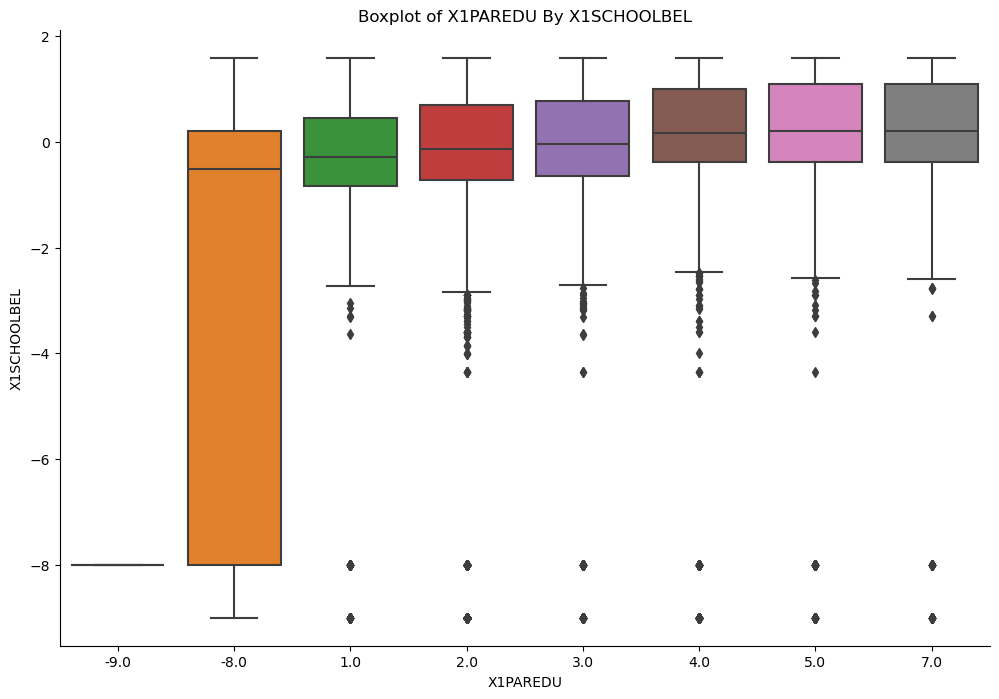

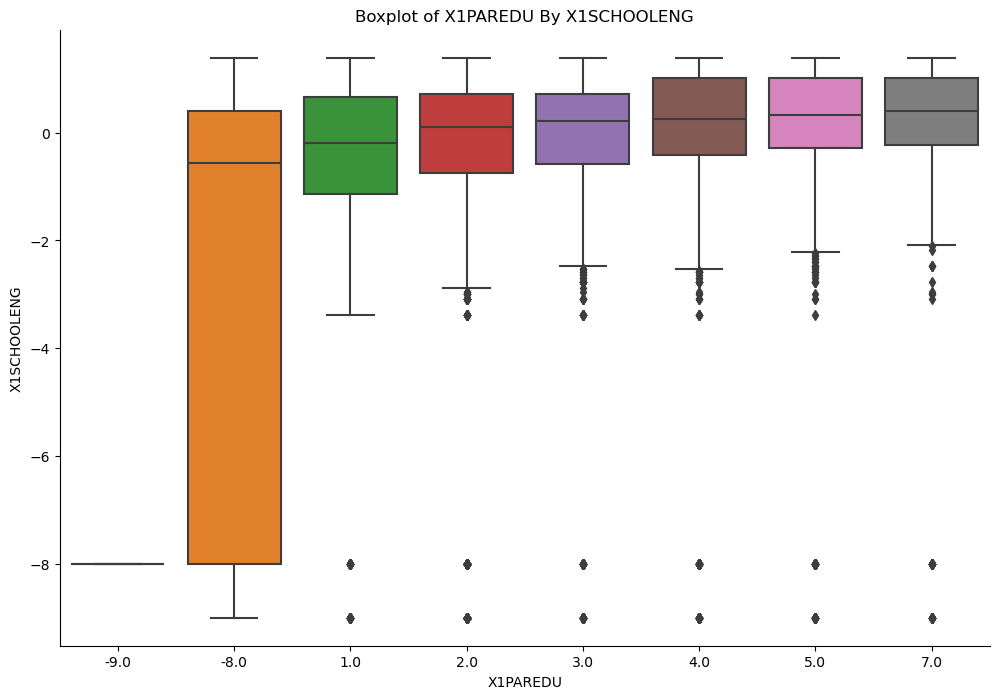

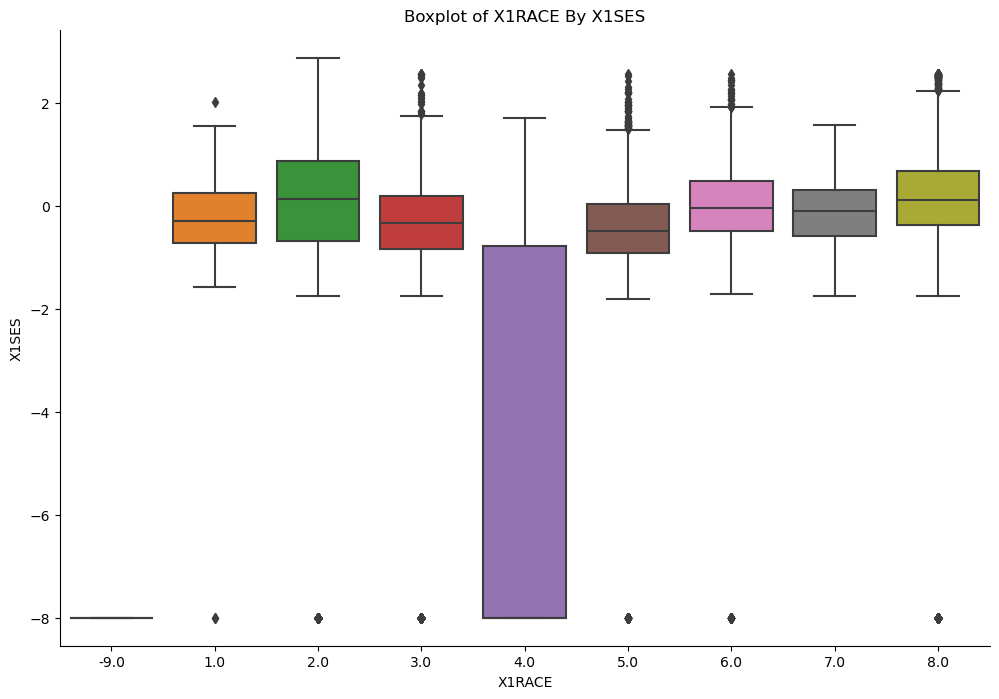

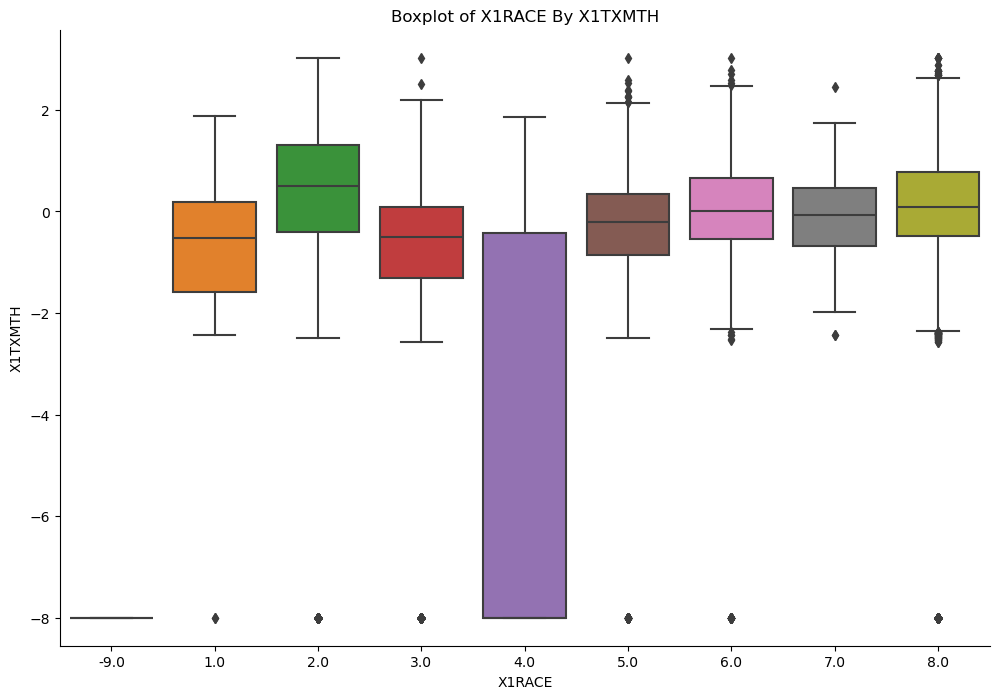

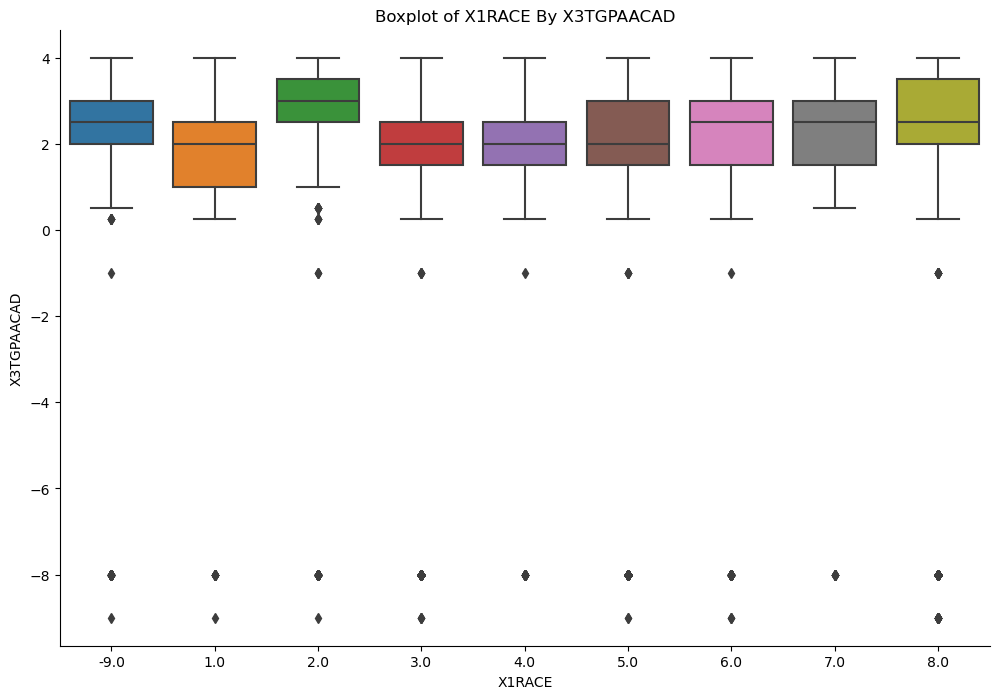

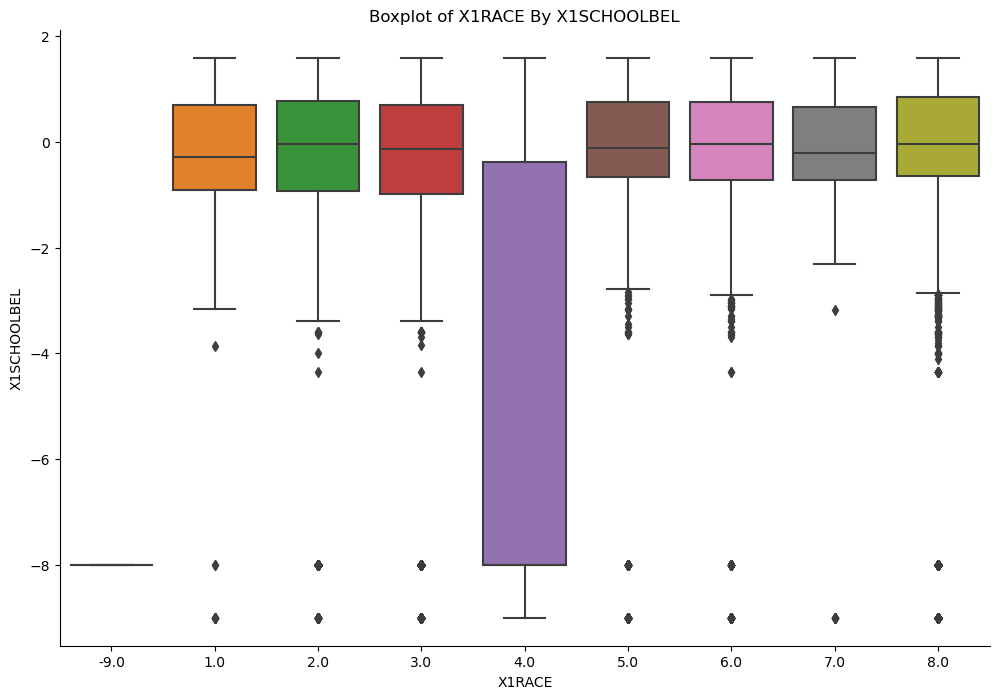

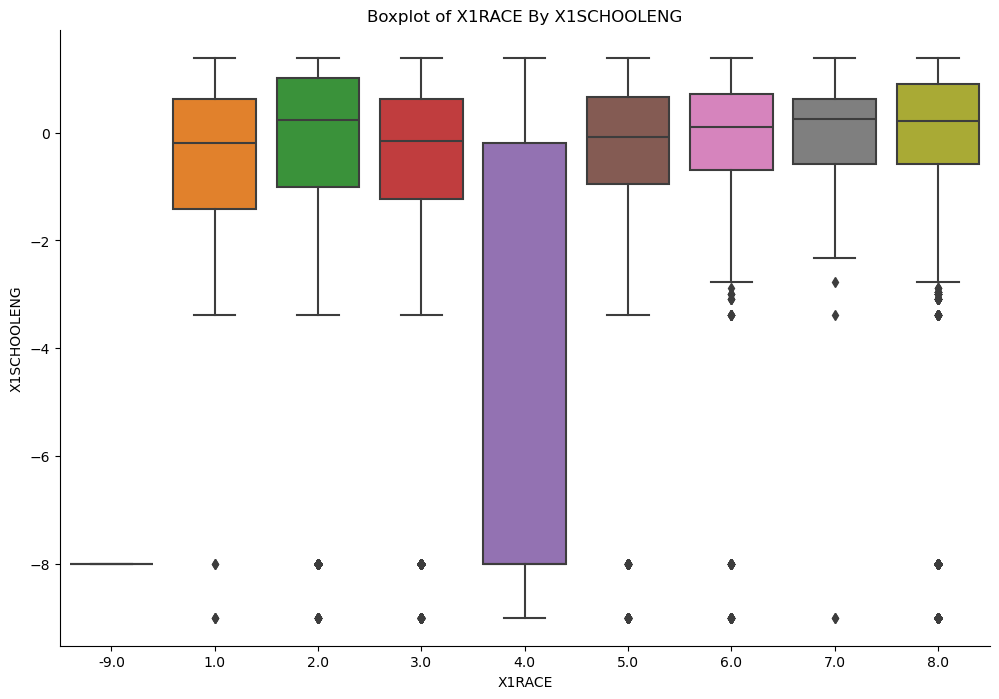

In [11]:
# Check if values of -8 show some different perspective in the data that is otherwise not represented
for cat in ['X1SESQ5', 'X1FAMINCOME', 'X1PAREDU', 'X1RACE']:
    for cont in continous_vars:
        plt.figure(figsize=(12, 8))
        sns.boxplot(data = hsls_school_relevant_clean, x = f'{cat}', y = f'{cont}')
        sns.despine()
        plt.title(f'Boxplot of {cat} By {cont}')
        plt.show()

Thee plots show clearly that the missing values generally coincide with other missing values or at the very most just do not add any unique and interesting information to the dataset.

In [12]:
# Show how much missing data exists
print('Appearances of -8')
display((hsls_school_relevant_clean == -8).sum().reset_index())
print('Appearances of -9')
display((hsls_school_relevant_clean == -9).sum().reset_index())

Appearances of -8


,index,0
0,STU_ID,0
1,X1SES,2059
2,X1SESQ5,2059
3,X1FAMINCOME,6715
4,X1PAREDU,6715
5,X1PAR1EMP,6715
6,X1TXMTH,2059
7,X3TGPAACAD,1575
8,X3EVERDROP,0
9,X1SEX,0


Appearances of -9


,index,0
0,STU_ID,0
1,X1SES,0
2,X1SESQ5,0
3,X1FAMINCOME,27
4,X1PAREDU,6
5,X1PAR1EMP,27
6,X1TXMTH,0
7,X3TGPAACAD,40
8,X3EVERDROP,0
9,X1SEX,6


While it looks like there are no null values, looking at the value counts and encoding notes, we see that many negative values are actually different kinds of missing data.

Dos not add anything different to the mix! Better to take a pure sample since there will still be over 10,000 rows.

In [13]:
# Remove missing values if unit non-response
## Imputing them could cause problems with bias, no better to simply drop them
hsls_school_relevant_clean = hsls_school_relevant_clean[(~hsls_school_relevant_clean[continous_vars + categorical_vars].isin([-8]).any(axis=1)) &
                                                        (hsls_school_relevant_clean['X3TGPAACAD'] != -1) &
                                                        (hsls_school_relevant_clean['X1RACE'] != -9) & 
                                                        (hsls_school_relevant_clean['X1SEX'] != -9) 
                                                        ]

In [14]:
# Set up for imputation of missing values (actually missing, designated by -9)
# Must set -9 to null 
hsls_school_relevant_clean_imputer = hsls_school_relevant_clean.copy()
hsls_school_relevant_clean_imputer = hsls_school_relevant_clean_imputer.map(specifyMissingness)

# Impute with knn and reset to dataframe
imputer = KNNImputer(n_neighbors=5)
hsls_school_relevant_clean_imputer = imputer.fit_transform(hsls_school_relevant_clean_imputer)
hsls_school_relevant_clean_imputer = pd.DataFrame(hsls_school_relevant_clean_imputer, columns = hsls_school_relevant_clean.columns)

# This transforms the categorical vars to whole numbers and types them as category
for col in categorical_vars:
    hsls_school_relevant_clean_imputer[col] = hsls_school_relevant_clean_imputer[col].round().astype('category')

In [15]:
# Save cleaned and Knn imputed dataset as simple name and correctly code the variables
## The convention for X3TGPAACAD is that it is rounded to the nearest half, so we will stay consistent
hsls_school_relevant_clean_imputer['X3TGPAACAD'] = round(hsls_school_relevant_clean_imputer['X3TGPAACAD'] * 2)/2
hsls = hsls_school_relevant_clean_imputer.copy()

The rounding of `X3GPAACAD` could be alarming since we consider it continuous, but we will transform it into a categorical variable since it will be used as a dependent variable, so the lack of precise numbers does not matter in our case. Of course, the exact numbers are likely not going to alter the analysis much since they are very close to the rounded version.

In [16]:
# Show values counts and variable info again
for var in hsls.columns:
    print(var, ':\n', meta.column_names_to_labels[var])
    if var in meta.variable_value_labels:
        print(' Value Meaning:', meta.variable_value_labels[var])
    display(hsls[var].value_counts().sort_index().reset_index())

STU_ID :
 Student ID


,STU_ID,count
0,10001.0,1
1,10002.0,1
2,10003.0,1
3,10004.0,1
4,10005.0,1
...,...,...
15475,35200.0,1
15476,35203.0,1
15477,35204.0,1
15478,35205.0,1


X1SES :
 X1 Socio-economic status composite


,X1SES,count
0,-1.7526,19
1,-1.7157,43
2,-1.6616,34
3,-1.6338,6
4,-1.6176,7
...,...,...
6116,2.5372,2
6117,2.5466,4
6118,2.5574,1
6119,2.5668,30


X1SESQ5 :
 X1 Quintile coding of X1SES composite
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 1.0: 'First quintile (lowest)', 2.0: 'Second quintile', 3.0: 'Third quintile', 4.0: 'Fourth quintile', 5.0: 'Fifth quintile (highest)'}


,X1SESQ5,count
0,1.0,2662
1,2.0,2585
2,3.0,2689
3,4.0,2917
4,5.0,4627


X1FAMINCOME :
 X1 Total family income from all sources 2008
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 1.0: 'Family income less than or equal to $15,000', 2.0: 'Family income > $15,000 and <= $35,000', 3.0: 'Family income > $35,000 and <= $55,000', 4.0: 'Family income > $55,000 and <= $75,000', 5.0: 'Family income > $75,000 and <= $95,000', 6.0: 'Family income > $95,000 and <= $115,000', 7.0: 'Family income > $115,000 and <= $135,000', 8.0: 'Family income > $135,000 and <= $155,000', 9.0: 'Family income > $155,000 and <=$175,000', 10.0: 'Family income > $175,000 and <= $195,000', 11.0: 'Family income > $195,000 and <= $215,000', 12.0: 'Family income > $215,000 and <= $235,000', 13.0: 'Family income > $235,000'}


,X1FAMINCOME,count
0,1.0,1420
1,2.0,2814
2,3.0,2550
3,4.0,2317
4,5.0,1722
5,6.0,1375
6,7.0,896
7,8.0,697
8,9.0,344
9,10.0,220


X1PAREDU :
 X1 Parents'/guardians' highest level of education
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 0.0: 'No bio/adoptive/step-parent in household', 1.0: 'Less than high school', 2.0: 'High school diploma or GED', 3.0: "Associate's degree", 4.0: "Bachelor's degree", 5.0: "Master's degree", 7.0: 'Ph.D/M.D/Law/other high lvl prof degree'}


,X1PAREDU,count
0,1.0,921
1,2.0,5418
2,3.0,2365
3,4.0,3788
4,5.0,1970
5,7.0,1018


X1PAR1EMP :
 X1 Parent 1: employment status
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 1.0: 'P1 has never worked for pay', 2.0: 'P1 not currently working for pay', 3.0: 'P1 currently working PT (<35 hrs/wk)', 4.0: 'P1 currently working FT (>=35 hrs/wk)'}


,X1PAR1EMP,count
0,1.0,491
1,2.0,3787
2,3.0,2197
3,4.0,9005


X1TXMTH :
 X1 Mathematics theta score


,X1TXMTH,count
0,-2.5672,1
1,-2.5210,1
2,-2.5142,1
3,-2.5073,1
4,-2.5001,1
...,...,...
12381,2.8764,2
12382,2.9097,1
12383,2.9228,1
12384,2.9319,1


X3TGPAACAD :
 X3 GPA for all academic courses


,X3TGPAACAD,count
0,0.0,100
1,0.5,285
2,1.0,631
3,1.5,1402
4,2.0,2224
5,2.5,2853
6,3.0,3360
7,3.5,3136
8,4.0,1489


X3EVERDROP :
 X3 Ever dropout
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', -6.0: 'Component not applicable', -4.0: 'Item not administered: abbreviated interview', 0.0: 'No known dropout episode', 1.0: 'At least one known dropout episode'}


,X3EVERDROP,count
0,0.0,14007
1,1.0,1473


X1SEX :
 X1 Student's sex
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 1.0: 'Male', 2.0: 'Female'}


,X1SEX,count
0,1.0,7757
1,2.0,7723


X1RACE :
 X1 Student's race/ethnicity-composite
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 0.0: 'No bio/adoptive/step-parent in household', 1.0: 'Amer. Indian/Alaska Native, non-Hispanic', 2.0: 'Asian, non-Hispanic', 3.0: 'Black/African-American, non-Hispanic', 4.0: 'Hispanic, no race specified', 5.0: 'Hispanic, race specified', 6.0: 'More than one race, non-Hispanic', 7.0: 'Native Hawaiian/Pacific Islander, non-Hispanic', 8.0: 'White, non-Hispanic'}


,X1RACE,count
0,1.0,110
1,2.0,1167
2,3.0,1470
3,4.0,101
4,5.0,2324
5,6.0,1349
6,7.0,77
7,8.0,8882


X1POVERTY :
 X1 Poverty indicator (relative to 100% of Census poverty threshold)
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 0.0: 'At or above poverty threshold', 1.0: 'Below poverty threshold'}


,X1POVERTY,count
0,0.0,13039
1,1.0,2441


X1LOCALE :
 X1 School locale (urbanicity)
 Value Meaning: {-9.0: 'Missing', -8.0: 'Unit non-response', -7.0: 'Item legitimate skip/NA', 1.0: 'City', 2.0: 'Suburb', 3.0: 'Town', 4.0: 'Rural'}


,X1LOCALE,count
0,1.0,4419
1,2.0,5470
2,3.0,1855
3,4.0,3736


X1SCHOOLBEL :
 X1 Scale of student's sense of school belonging


,X1SCHOOLBEL,count
0,-4.35,10
1,-4.02,2
2,-4.00,2
3,-3.87,2
4,-3.85,1
...,...,...
766,1.23,143
767,1.26,364
768,1.34,715
769,1.39,1


X1SCHOOLENG :
 X1 Scale of student's school engagement


,X1SCHOOLENG,count
0,-3.380,38
1,-3.080,32
2,-3.000,13
3,-2.950,6
4,-2.890,2
...,...,...
501,0.994,1
502,1.010,1459
503,1.090,447
504,1.238,1


In [17]:
hsls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15480 entries, 0 to 15479
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   STU_ID       15480 non-null  category
 1   X1SES        15480 non-null  float64 
 2   X1SESQ5      15480 non-null  category
 3   X1FAMINCOME  15480 non-null  category
 4   X1PAREDU     15480 non-null  category
 5   X1PAR1EMP    15480 non-null  category
 6   X1TXMTH      15480 non-null  float64 
 7   X3TGPAACAD   15480 non-null  float64 
 8   X3EVERDROP   15480 non-null  category
 9   X1SEX        15480 non-null  category
 10  X1RACE       15480 non-null  category
 11  X1POVERTY    15480 non-null  category
 12  X1LOCALE     15480 non-null  category
 13  X1SCHOOLBEL  15480 non-null  float64 
 14  X1SCHOOLENG  15480 non-null  float64 
dtypes: category(10), float64(5)
memory usage: 1.4 MB


## Data Exploration

In [18]:
# Describe continuous (numeric) variables
print("Continuous descriptive statistics:")
display(hsls.describe())

# Describe categorical variables
print("Categorical descriptive statistics:")
display(hsls.describe(include=['category']))

Continuous descriptive statistics:


,X1SES,X1TXMTH,X3TGPAACAD,X1SCHOOLBEL,X1SCHOOLENG
count,15480.000000,15480.000000,15480.000000,15480.000000,15480.000000
mean,0.094544,0.140305,2.678876,0.128441,0.113472
std,0.836862,0.959110,0.879514,0.961213,0.950751
min,-1.752600,-2.567200,0.000000,-4.350000,-3.380000
25%,-0.538100,-0.441850,2.000000,-0.390000,-0.470000
50%,0.020800,0.112250,3.000000,0.020000,0.230000
75%,0.684600,0.809325,3.500000,0.920000,0.960000
max,2.880700,3.028300,4.000000,1.590000,1.390000


Categorical descriptive statistics:


,STU_ID,X1SESQ5,X1FAMINCOME,X1PAREDU,X1PAR1EMP,X3EVERDROP,X1SEX,X1RACE,X1POVERTY,X1LOCALE
count,15480.0,15480.0,15480.0,15480.0,15480.0,15480.0,15480.0,15480.0,15480.0,15480.0
unique,15480.0,5.0,13.0,6.0,4.0,2.0,2.0,8.0,2.0,4.0
top,10001.0,5.0,2.0,2.0,4.0,0.0,1.0,8.0,0.0,2.0
freq,1.0,4627.0,2814.0,5418.0,9005.0,14007.0,7757.0,8882.0,13039.0,5470.0


/Users/matthewduffy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


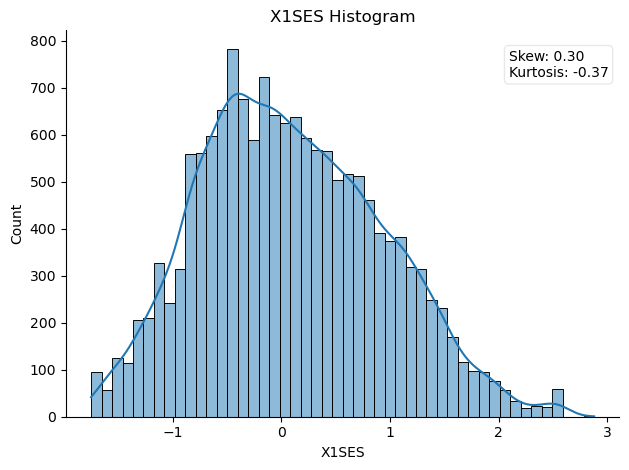

/Users/matthewduffy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


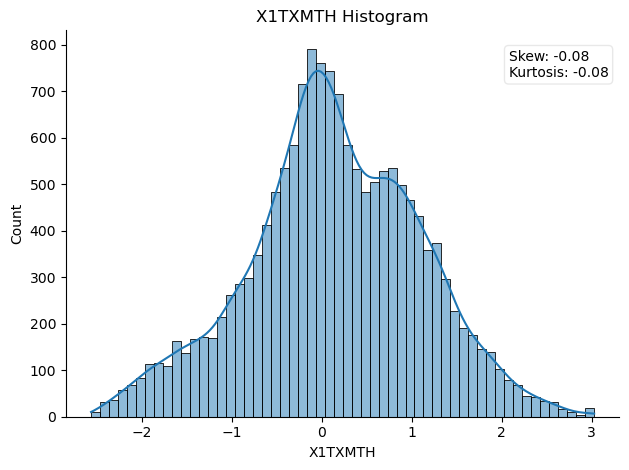

/Users/matthewduffy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


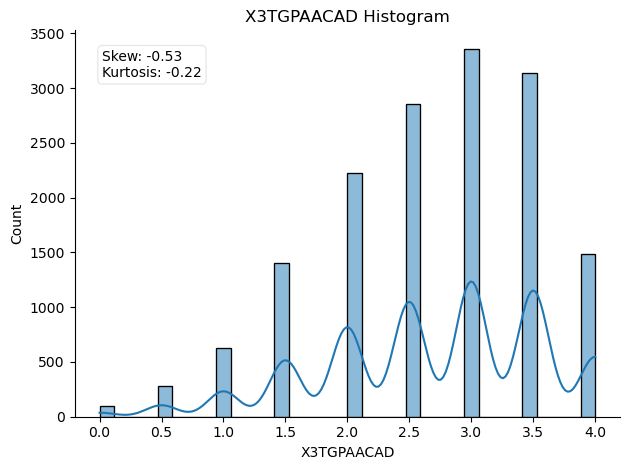

/Users/matthewduffy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


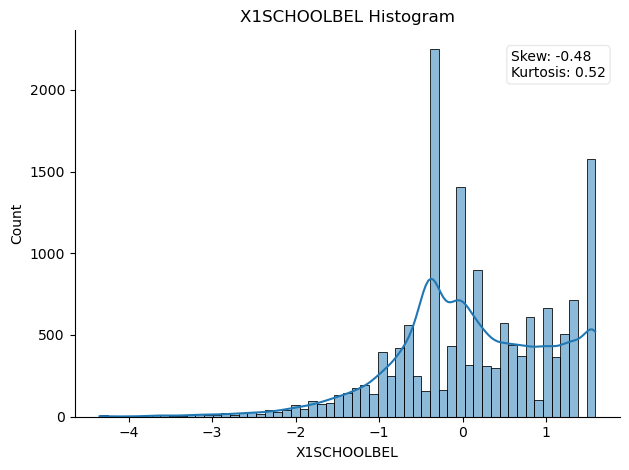

/Users/matthewduffy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


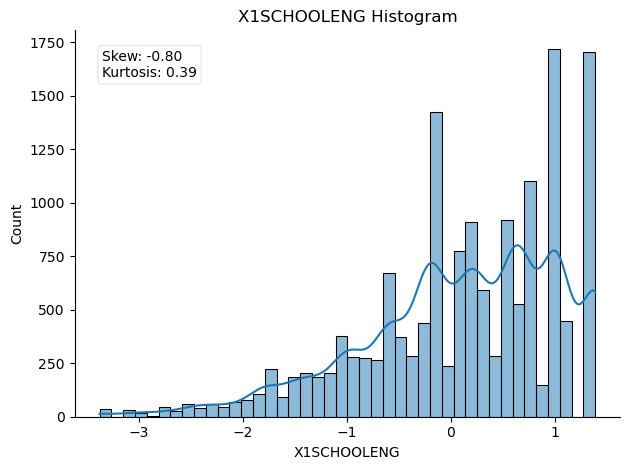

In [19]:
# Graph distributions 
for var in continous_vars:
    plt.figure()
    
    # Drop missing values
    data = hsls[var].dropna()
    
    # Plot histogram with KDE
    sns.histplot(data, kde=True)
    
    # Calculate skew and kurtosis
    sk = skew(data)
    kt = kurtosis(data, fisher=True)
    
    plt.text(
    0.05 if sk < -0.5 else 0.8, 0.95,
    f'Skew: {sk:.2f}\nKurtosis: {kt:.2f}',
    transform=plt.gca().transAxes,
    verticalalignment='top',
    fontsize=10,
    bbox=dict(
        boxstyle='round,pad=0.3',
        facecolor='white',       # Light background
        edgecolor='lightgray',   # Softer border
        linewidth=1,
        alpha=0.5                # Semi-transparent
    )
)
    
    # Title and style
    plt.title(f'{var} Histogram')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()


In [20]:
meanAvgChange = hsls.groupby('X1SESQ5')[continous_vars].mean().reset_index().drop(columns='X1SES')
meanAvgChange.round(4)

/var/folders/55/hm3403kd49v7n8cq2cpq4ky80000gn/T/ipykernel_22573/110860452.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  meanAvgChange = hsls.groupby('X1SESQ5')[continous_vars].mean().reset_index().drop(columns='X1SES')


,X1SESQ5,X1TXMTH,X3TGPAACAD,X1SCHOOLBEL,X1SCHOOLENG
0,1.0,-0.3858,2.1352,-0.0777,-0.1055
1,2.0,-0.1700,2.4050,-0.0204,0.0122
2,3.0,0.0279,2.6026,0.0798,0.0810
3,4.0,0.2271,2.7777,0.1783,0.1724
4,5.0,0.6270,3.1266,0.3271,0.2777


In [21]:
meanAvgChange = hsls.groupby('X1RACE')[continous_vars].mean().reset_index().drop(columns='X1SES')
meanAvgChange.round(4)

/var/folders/55/hm3403kd49v7n8cq2cpq4ky80000gn/T/ipykernel_22573/4025039015.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  meanAvgChange = hsls.groupby('X1RACE')[continous_vars].mean().reset_index().drop(columns='X1SES')


,X1RACE,X1TXMTH,X3TGPAACAD,X1SCHOOLBEL,X1SCHOOLENG
0,1.0,-0.4667,2.1545,-0.0634,-0.3655
1,2.0,0.8511,3.1817,0.2560,0.3798
2,3.0,-0.3291,2.2432,0.1276,0.0159
3,4.0,-0.4380,2.0099,-0.0725,-0.1570
4,5.0,-0.1445,2.3793,0.0624,-0.0671
5,6.0,0.1341,2.5975,0.0224,0.0266
6,7.0,0.0727,2.4805,0.0401,0.0668
7,8.0,0.2147,2.7915,0.1506,0.1645


In [22]:
# Compute correlation matrix
corr, p_value_matrix = generate_correlations_pvalues(hsls[continous_vars])

display(corr)
display(p_value_matrix)

,X1SES,X1TXMTH,X3TGPAACAD,X1SCHOOLBEL,X1SCHOOLENG
X1SES,-,,,,
X1TXMTH,0.408*,-,,,
X3TGPAACAD,0.416*,0.559*,-,,
X1SCHOOLBEL,0.164*,0.181*,0.244*,-,
X1SCHOOLENG,0.146*,0.205*,0.327*,0.289*,-


,X1SES,X1TXMTH,X3TGPAACAD,X1SCHOOLBEL,X1SCHOOLENG
X1SES,-,,,,
X1TXMTH,0.0000,-,,,
X3TGPAACAD,0.0000,0.0000,-,,
X1SCHOOLBEL,0.0000,0.0000,0.0000,-,
X1SCHOOLENG,0.0000,0.0000,0.0000,0.0000,-


/var/folders/55/hm3403kd49v7n8cq2cpq4ky80000gn/T/ipykernel_22573/3911235590.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_n = corr_mask.replace({'\*': ''}, regex=True).astype(float)


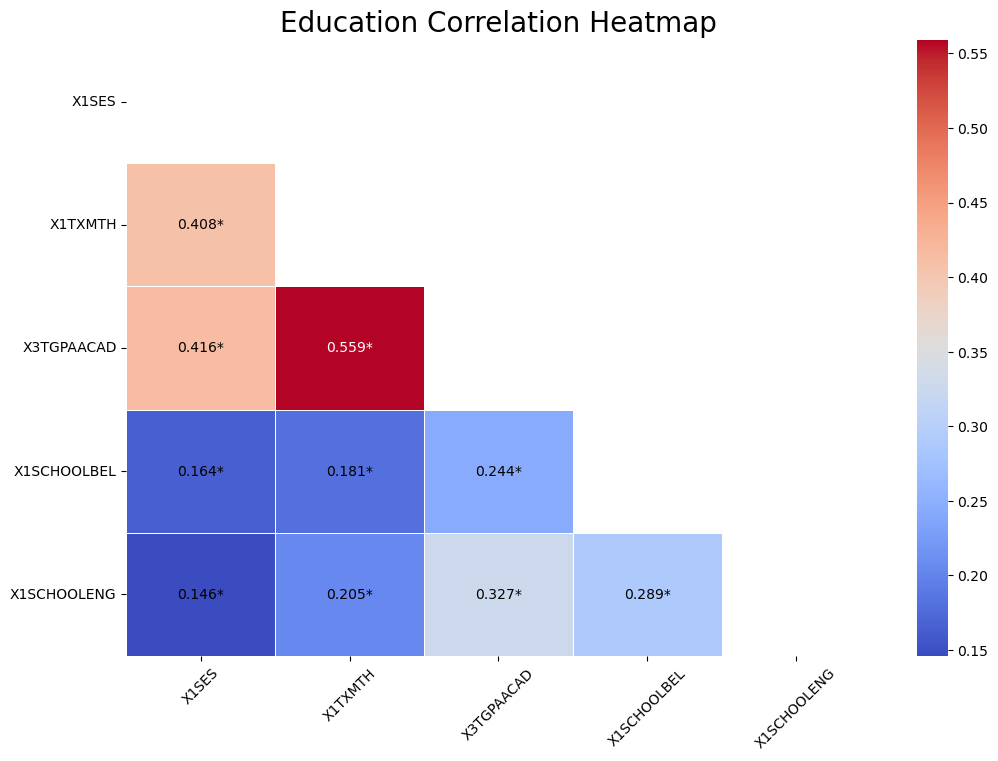

In [23]:
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
corr_mask = corr.mask(mask)
corr_n = corr_mask.replace({'\*': ''}, regex=True).astype(float)
sns.heatmap(corr_n, mask=mask, cmap='coolwarm', linewidths=0.5)

for i in range(corr_n.shape[0]):
    for j in range(corr_n.shape[1]):
        if not corr.iloc[i, j] == '-':
            if abs(corr_n.iloc[i, j]) >= 0.5:
                plt.annotate(corr.iloc[i, j],
                    xy=(j + 0.5, i + 0.5),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white')
            else:
                plt.annotate(corr.iloc[i, j],
                    xy=(j + 0.5, i + 0.5),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='black')
            
# Set the title
plt.title('Education Correlation Heatmap', fontsize=20)

# Ensure yticks match the heatmap
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Save the figure (optional)
# plt.savefig('Figs/heatmap.png', dpi=400, bbox_inches='tight')
plt.show()


So, it is not quite that lower socioeconomic class means lower grades (even though that can be true), but people with higher socioeconomic status generally do better in school.

/Users/matthewduffy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/matthewduffy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


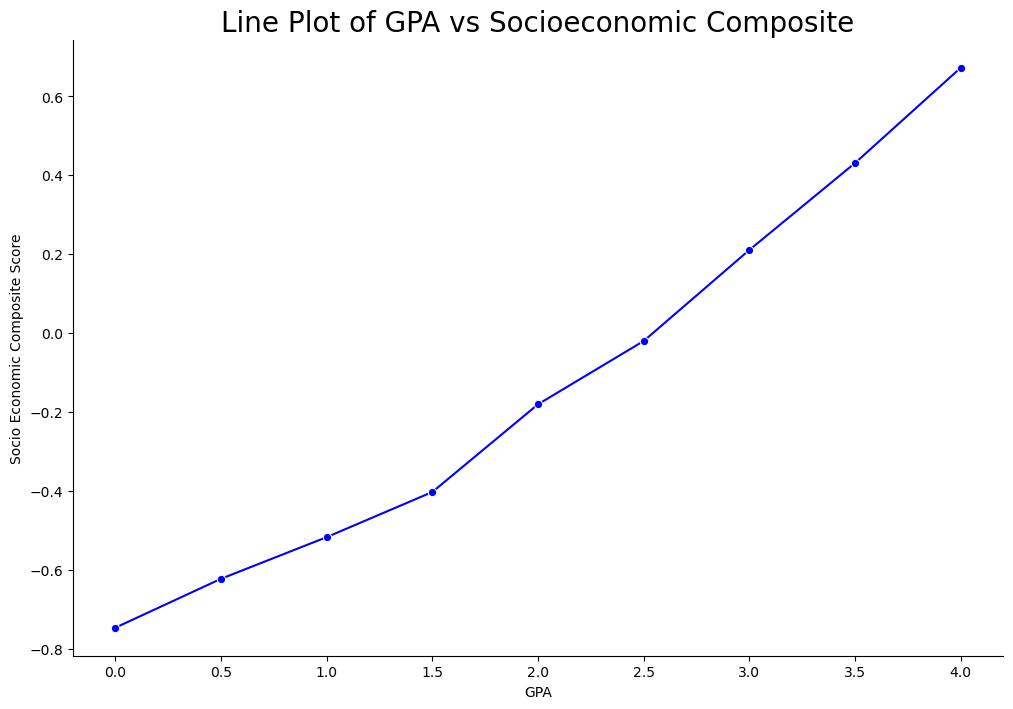

In [24]:
# Assuming your DataFrame is called df and has 'GPA' and 'school_wellbeing' columns
plt.figure(figsize=(12, 8))
sns.lineplot(data=hsls, x='X3TGPAACAD', y='X1SES', color='blue', errorbar=None, marker='o')
sns.despine()

plt.title('Line Plot of GPA vs Socioeconomic Composite', fontsize=20)
plt.xlabel('GPA')
plt.ylabel('Socio Economic Composite Score')

plt.show()

/var/folders/55/hm3403kd49v7n8cq2cpq4ky80000gn/T/ipykernel_22573/3559161087.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = hsls.groupby(indepVar)[depVar].mean()


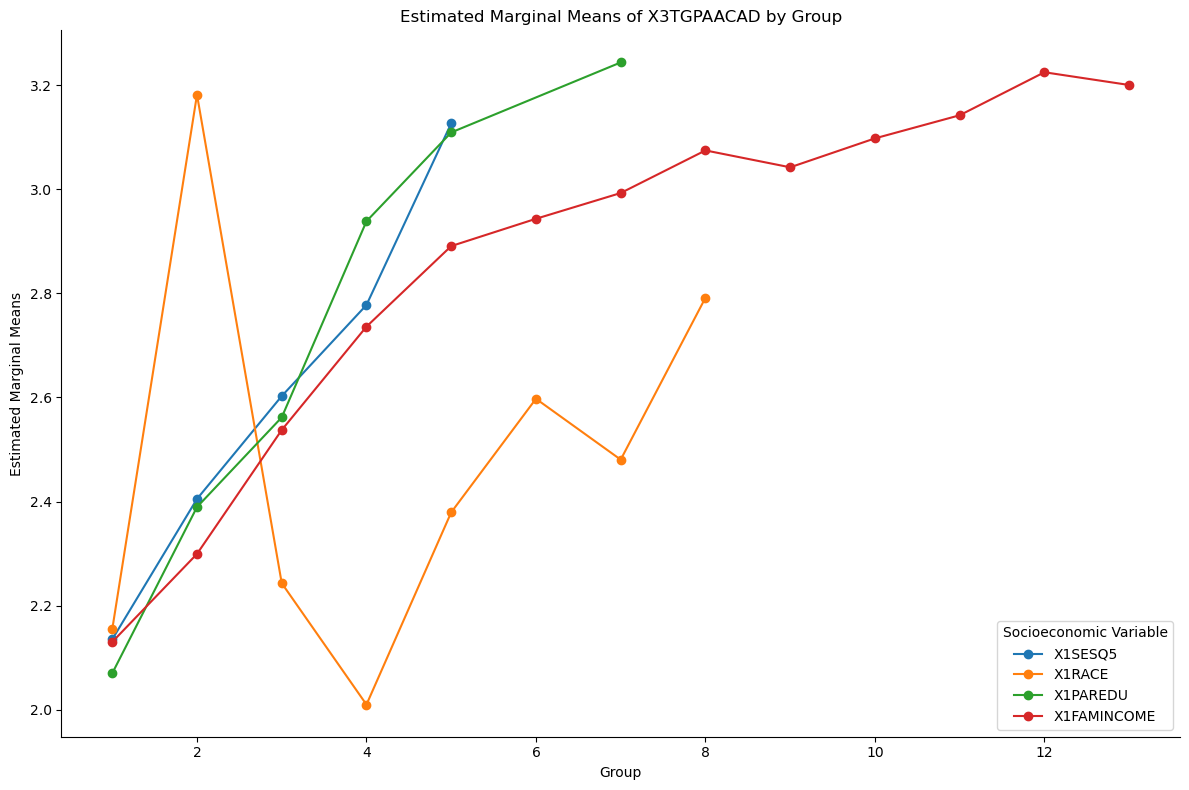

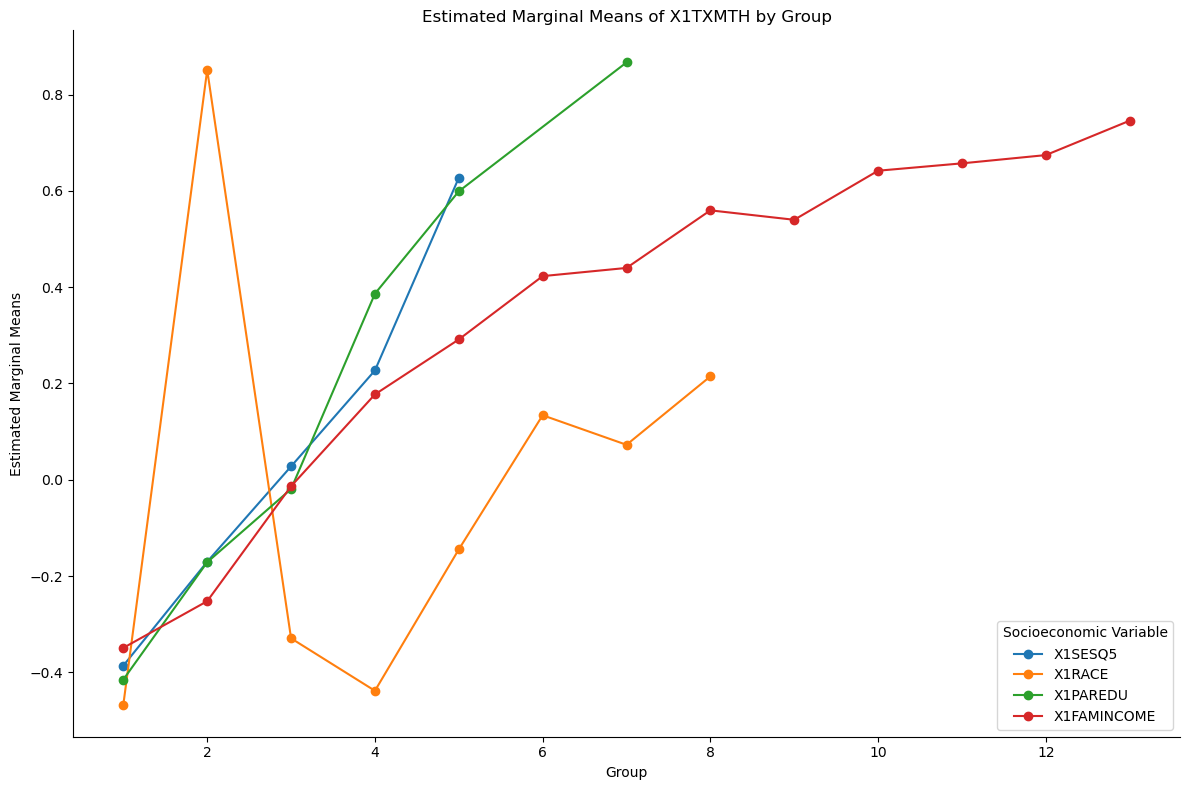

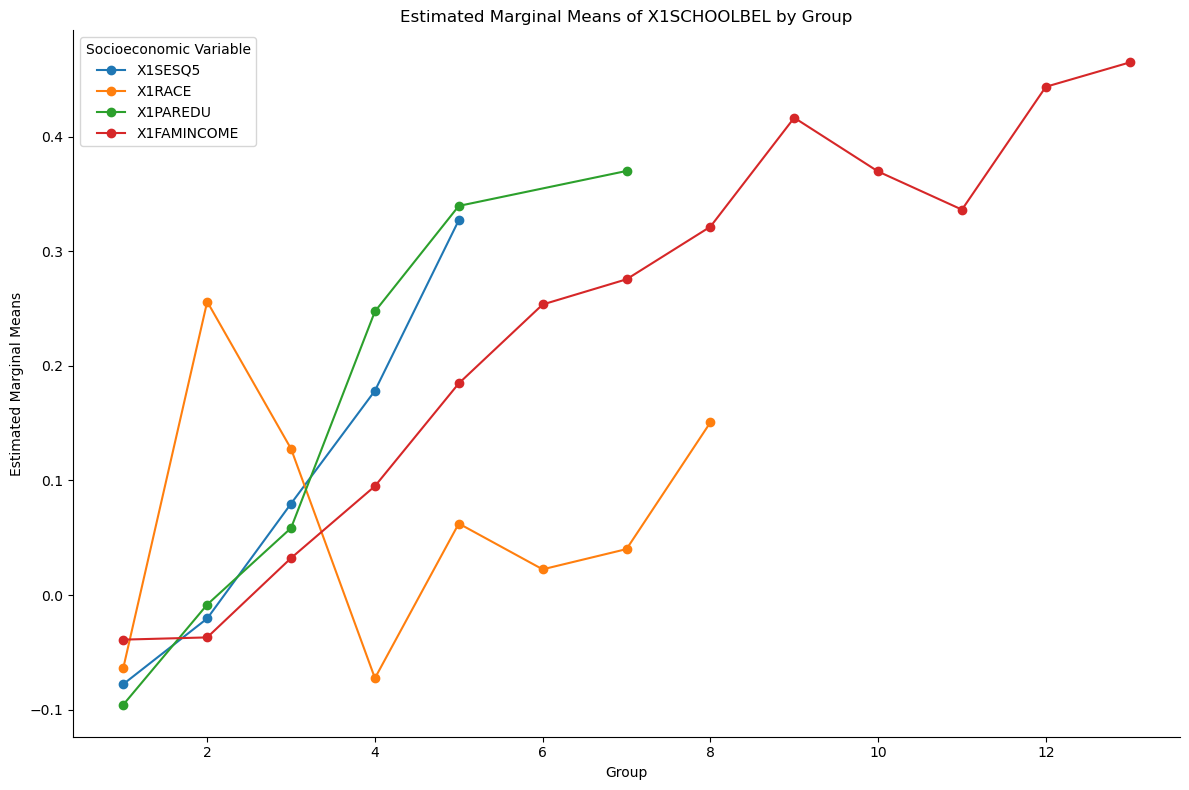

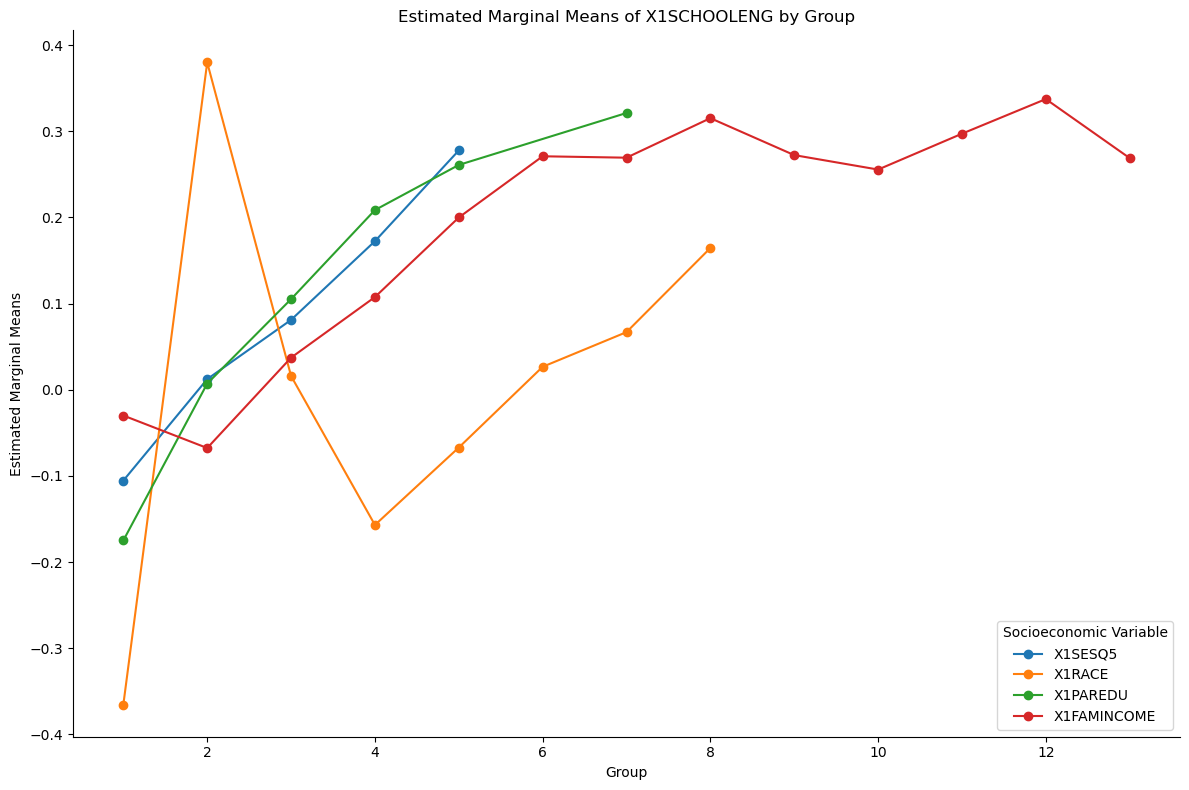

In [25]:
# Define socio economic vars and success cars
socioEconomicVars = ['X1SESQ5', 'X1RACE', 'X1PAREDU', 'X1FAMINCOME']
successVars = ['X3TGPAACAD', 'X1TXMTH', 'X1SCHOOLBEL', 'X1SCHOOLENG']

# Loop to construct mean group graphs
for depVar in successVars:
    plt.figure(figsize=(12, 8))
    for indepVar in socioEconomicVars:
        means = hsls.groupby(indepVar)[depVar].mean()
        plt.plot(means.index, means.values, marker='o', label=indepVar)
    plt.xlabel('Group')
    plt.ylabel('Estimated Marginal Means')
    plt.title(f'Estimated Marginal Means of {depVar} by Group')
    plt.legend(title='Socioeconomic Variable')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

## Modelling

### Cluster Analysis

#### Data Set Up

In [26]:
# Create new df for clustering
hsls_cluster = hsls.copy() 
print(f'Rows before outliers removed: {hsls_cluster.shape[0]}')
hsls_cluster = remove_outliers(hsls_cluster, threshold=2)
print(f'Rows after outliers removed: {hsls_cluster.shape[0]}')
scaler = StandardScaler()
hsls_cluster_z = scaler.fit_transform(hsls_cluster[continous_vars])
hsls_cluster_z = pd.DataFrame(hsls_cluster_z, columns=continous_vars)

Rows before outliers removed: 15480
Rows after outliers removed: 15360


#### Assumptions

**Existing Structure**

- I claim that there is some variation between those of higher socioeconomic status and lower socioeconomic. There could be tiers to this, but there should be at least two different clusters.

**Sample Representativeness**

- This dataset comes from the National Center for Educational Statistics (NCES). Data was collected from over 25,000 students that started high school in 2009. Earlier, this data was cleaned by removing missing values (it was checked that the missing values did not account for some unrepresented group (seeing that there were no unique grouping between the missing values and any variable being studied in this analysis)). Thus, the sample findings should be generalizable to the population.

**Multicollinearity**

- There is no alarming VIF score to suggest multicollinearity being a problem between the continuous variables!

In [27]:
# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = continous_vars
vif_data["VIF"] = [variance_inflation_factor(hsls_cluster[continous_vars].values.astype(int), i) for i in range(hsls_cluster[continous_vars].shape[1])]
vif_data["Tolerance"] = 1 / vif_data["VIF"]
vif_data

,Variable,VIF,Tolerance
0,X1SES,1.152302,0.867828
1,X1TXMTH,1.169228,0.855265
2,X3TGPAACAD,1.196976,0.835439
3,X1SCHOOLBEL,1.123090,0.890401
4,X1SCHOOLENG,1.091460,0.916204


#### Clustering

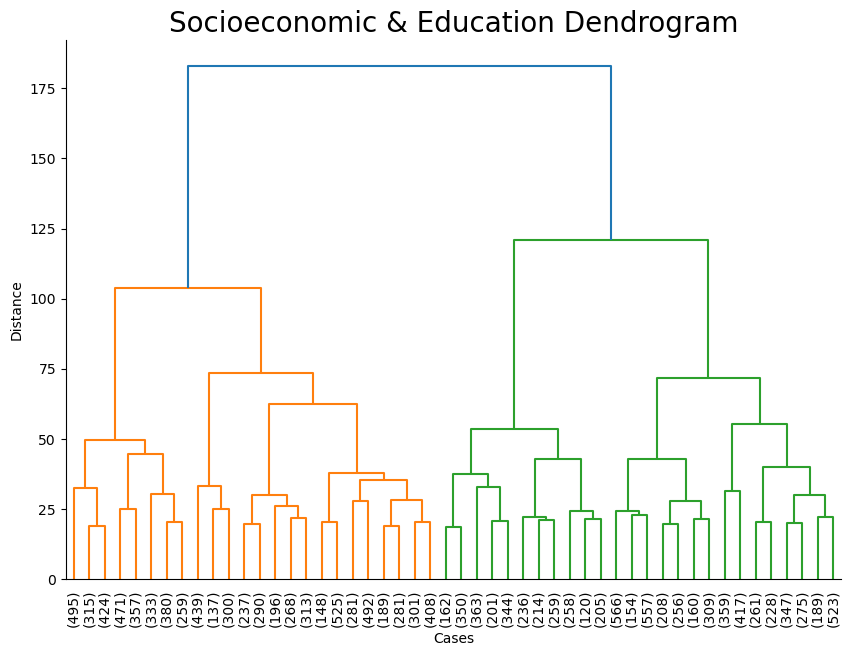

In [28]:
# Form linkage and plot dendrogram (up to 50)
linkage_matrix = linkage(hsls_cluster_z, method='ward', metric='euclidean')

cluster_combined = linkage_matrix[:, :2].astype(int)  # Combined clusters
agglomeration_coefficients = linkage_matrix[:, 2]  # Agglomeration coefficient
cluster_sizes = linkage_matrix[:, 3].astype(int)  # Size of the resulting cluster

# Plot 
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix, labels=hsls_cluster_z.index.tolist(), orientation='top', truncate_mode='lastp', p=50, leaf_rotation=90., leaf_font_size=10.)
plt.title("Socioeconomic & Education Dendrogram", fontsize = 20)
plt.xlabel("Cases")
plt.ylabel("Distance")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

In [29]:
# Perform K-means clustering with predefined initial centroids
kmeans = KMeans(n_clusters=2, init='k-means++', n_init='auto', random_state=42)
hsls_cluster_z['QCL_1'] = kmeans.fit_predict(hsls_cluster_z)
hsls_cluster['Cluster'] = hsls_cluster_z['QCL_1']

# Final cluster centers (in standardized space)
final_centers = kmeans.cluster_centers_

# Create a DataFrame for easier inspection
final_centers_df = pd.DataFrame(final_centers, columns=continous_vars)
final_centers_transposed = final_centers_df.T

# Calculate cluster centers
cluster_centers = hsls_cluster_z.groupby("QCL_1")[continous_vars].mean()

# Calculate the total mean for all variables
total_mean = hsls_cluster_z[continous_vars].mean()

# Add the total mean as a new row labeled "Total"
cluster_centers.loc['Total'] = total_mean

In [30]:
# Cluster counts
hsls_cluster['Cluster'].value_counts().reset_index()

,Cluster,count
0,0,8331
1,1,7029


Relatively even distribution across clusters

In [31]:
# Display the ANOVA table
print("\nANOVA Table:")
ANOVA_On_Cluster(hsls_cluster, continous_vars, 2)


ANOVA Table:


,Variable,Cluster Mean Square,Cluster df,Error Mean Square,Error df,F,P_Val
0,X1SES,3031.755518,1,0.502277,15358,6036.020478,0.0
1,X1TXMTH,5262.866904,1,0.571325,15358,9211.683775,0.0
2,X3TGPAACAD,5589.583349,1,0.402232,15358,13896.416300,0.0
3,X1SCHOOLBEL,1953.739692,1,0.726162,15358,2690.501734,0.0
4,X1SCHOOLENG,2489.596355,1,0.709193,15358,3510.461909,0.0


These ANOVA results indicate that the means for each variable each cluster mean is significantly different 

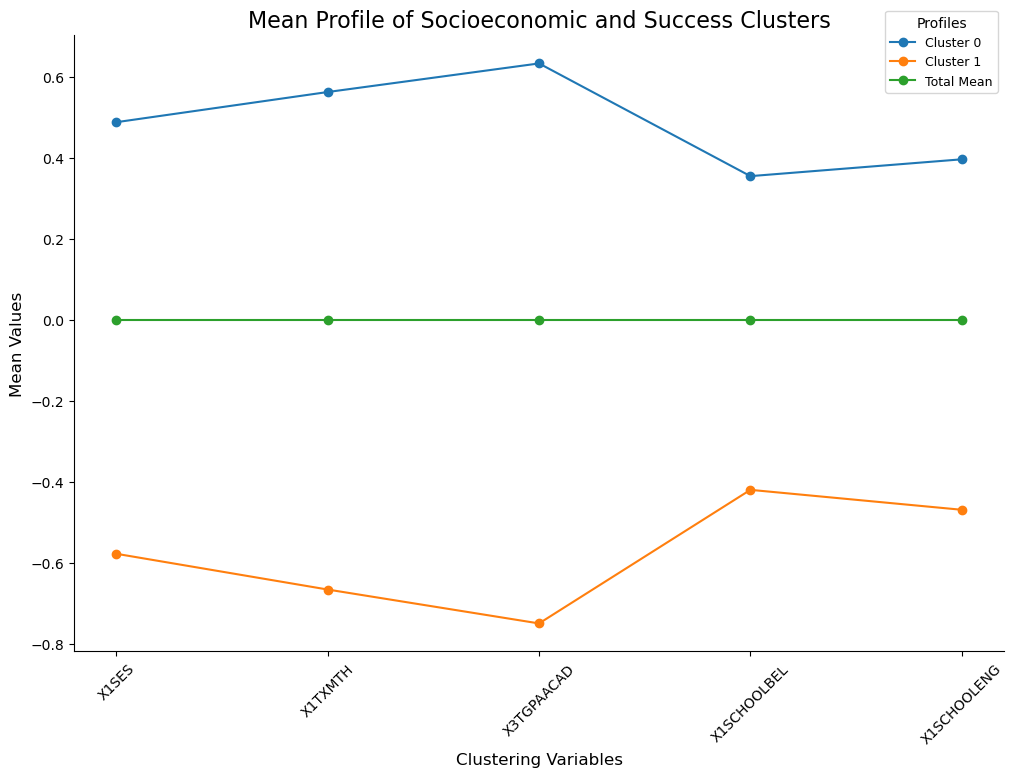

In [32]:
# Transpose the cluster_centers DataFrame for easier plotting
cluster_centers_transposed = cluster_centers.T

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each cluster's mean profile
for cluster in cluster_centers_transposed.columns:
    #if cluster != 'Total':
        plt.plot(
            cluster_centers_transposed.index,
            cluster_centers_transposed[cluster],
            marker='o',
            label=f"Cluster {cluster}" if cluster != 'Total' else 'Total Mean'
        )

# Customize the plot
plt.title("Mean Profile of Socioeconomic and Success Clusters", fontsize=16)
plt.xlabel("Clustering Variables", fontsize=12)
plt.ylabel("Mean Values", fontsize=12)
plt.xticks(fontsize=10, rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title="Profiles", fontsize=9, loc='upper right',
    bbox_to_anchor=(1, 1.05))  # Horizontal layout
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Display the plot
plt.show()

In [33]:
# Unstandardized graph data
hsls_cluster.groupby('Cluster')[continous_vars].mean().reset_index()

,Cluster,X1SES,X1TXMTH,X3TGPAACAD,X1SCHOOLBEL,X1SCHOOLENG
0,0,0.506395,0.684376,3.239587,0.477814,0.494806
1,1,-0.385363,-0.490553,2.028738,-0.238055,-0.313293


In [34]:
cluster_counts = hsls_cluster[['X1FAMINCOME', 'Cluster']].value_counts().reset_index().sort_values(['X1FAMINCOME', 'Cluster'])
cluster_counts['PercentOfGroup'] = cluster_counts['count']/cluster_counts.groupby('X1FAMINCOME')['count'].transform('sum') * 100
cluster_counts['Income Level'] = cluster_counts['X1FAMINCOME'].map(meta.variable_value_labels['X1FAMINCOME'])
cluster_counts.reset_index(drop=True)

/var/folders/55/hm3403kd49v7n8cq2cpq4ky80000gn/T/ipykernel_22573/1869822600.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_counts['PercentOfGroup'] = cluster_counts['count']/cluster_counts.groupby('X1FAMINCOME')['count'].transform('sum') * 100


,X1FAMINCOME,Cluster,count,PercentOfGroup,Income Level
0,1.0,0,256,18.311874,"Family income less than or equal to $15,000"
1,1.0,1,1142,81.688126,"Family income less than or equal to $15,000"
2,2.0,0,736,26.503421,"Family income > $15,000 and <= $35,000"
3,2.0,1,2041,73.496579,"Family income > $15,000 and <= $35,000"
4,3.0,0,1121,44.343354,"Family income > $35,000 and <= $55,000"
5,3.0,1,1407,55.656646,"Family income > $35,000 and <= $55,000"
6,4.0,0,1296,56.298871,"Family income > $55,000 and <= $75,000"
7,4.0,1,1006,43.701129,"Family income > $55,000 and <= $75,000"
8,5.0,0,1147,66.958552,"Family income > $75,000 and <= $95,000"
9,5.0,1,566,33.041448,"Family income > $75,000 and <= $95,000"


Cluster 1 is made of people of lower socioeconomic status and cluster 2 is made up on people of higher economic status. Clearly, based on `X1FAMINCOME`, the higher the income category the more likely it is that the people are in cluster 1 and not cluster 0.

In [35]:
# Altered cluster analyses
hsls_cluster_z_just_stud = hsls_cluster_z.drop(columns = ['X1SES', 'QCL_1']).copy()
successVars = hsls_cluster_z_just_stud.columns

# Perform K-means clustering with predefined initial centroids
kmeans = KMeans(n_clusters=2, init='k-means++', n_init='auto', random_state=42)
hsls_cluster_z_just_stud['QCL_1'] = kmeans.fit_predict(hsls_cluster_z_just_stud)
hsls_cluster['Cluster_Accad'] = hsls_cluster_z_just_stud['QCL_1']

# Final cluster centers (in standardized space)
final_centers = kmeans.cluster_centers_

# Create a DataFrame for easier inspection
final_centers_df = pd.DataFrame(final_centers, columns=successVars)
final_centers_transposed = final_centers_df.T

# Calculate cluster centers
cluster_centers = hsls_cluster_z_just_stud.groupby("QCL_1")[successVars].mean()

# Calculate the total mean for all variables
total_mean = hsls_cluster_z_just_stud[successVars].mean()

# Add the total mean as a new row labeled "Total"
cluster_centers.loc['Total'] = total_mean

In [36]:
hsls_cluster['Cluster_Accad'].value_counts()

Cluster_Accad
0    8662
1    6698
Name: count, dtype: int64

In [37]:
# Display the ANOVA table
print("\nANOVA Table:")
ANOVA_On_Cluster(hsls_cluster, continous_vars, 2, 'Cluster_Accad')


ANOVA Table:


,Variable,Cluster Mean Square,Cluster df,Error Mean Square,Error df,F,P_Val
0,X1SES,1355.742752,1,0.611407,15358,2217.415114,0.0
1,X1TXMTH,5008.557869,1,0.587884,15358,8519.637532,0.0
2,X3TGPAACAD,5634.585861,1,0.399302,15358,14111.096654,0.0
3,X1SCHOOLBEL,2356.079549,1,0.699964,15358,3365.998975,0.0
4,X1SCHOOLENG,3418.823606,1,0.648689,15358,5270.359034,0.0


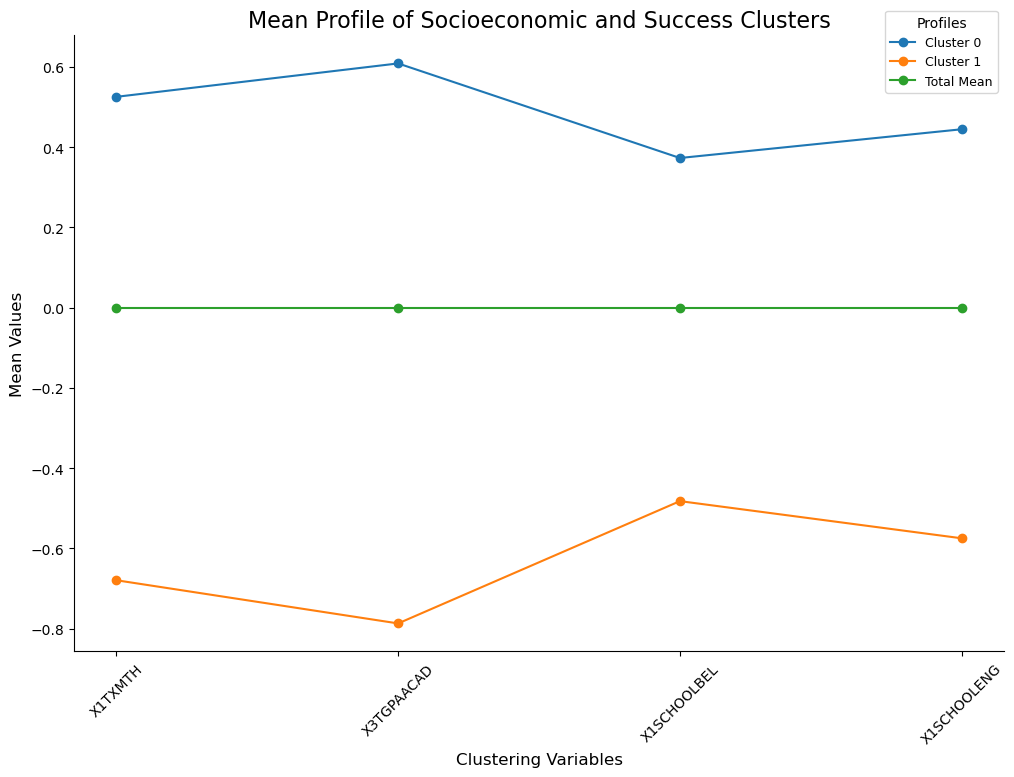

In [38]:
# Transpose the cluster_centers DataFrame for easier plotting
cluster_centers_transposed = cluster_centers.T

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each cluster's mean profile
for cluster in cluster_centers_transposed.columns:
    #if cluster != 'Total':
        plt.plot(
            cluster_centers_transposed.index,
            cluster_centers_transposed[cluster],
            marker='o',
            label=f"Cluster {cluster}" if cluster != 'Total' else 'Total Mean'
        )

# Customize the plot
plt.title("Mean Profile of Socioeconomic and Success Clusters", fontsize=16)
plt.xlabel("Clustering Variables", fontsize=12)
plt.ylabel("Mean Values", fontsize=12)
plt.xticks(fontsize=10, rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title="Profiles", fontsize=9, loc='upper right',
    bbox_to_anchor=(1, 1.05))  # Horizontal layout
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Display the plot
plt.show()

In [39]:
cluster_counts = hsls_cluster[['X1FAMINCOME', 'Cluster_Accad']].value_counts().reset_index().sort_values(['X1FAMINCOME', 'Cluster_Accad'])
cluster_counts['PercentOfGroup'] = cluster_counts['count']/cluster_counts.groupby('X1FAMINCOME')['count'].transform('sum') * 100
cluster_counts['Income Level'] = cluster_counts['X1FAMINCOME'].map(meta.variable_value_labels['X1FAMINCOME'])
cluster_counts.reset_index(drop=True)

/var/folders/55/hm3403kd49v7n8cq2cpq4ky80000gn/T/ipykernel_22573/592588558.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_counts['PercentOfGroup'] = cluster_counts['count']/cluster_counts.groupby('X1FAMINCOME')['count'].transform('sum') * 100


,X1FAMINCOME,Cluster_Accad,count,PercentOfGroup,Income Level
0,1.0,0,470,33.619456,"Family income less than or equal to $15,000"
1,1.0,1,928,66.380544,"Family income less than or equal to $15,000"
2,2.0,0,1006,36.226143,"Family income > $15,000 and <= $35,000"
3,2.0,1,1771,63.773857,"Family income > $15,000 and <= $35,000"
4,3.0,0,1237,48.931962,"Family income > $35,000 and <= $55,000"
5,3.0,1,1291,51.068038,"Family income > $35,000 and <= $55,000"
6,4.0,0,1325,57.558645,"Family income > $55,000 and <= $75,000"
7,4.0,1,977,42.441355,"Family income > $55,000 and <= $75,000"
8,5.0,0,1120,65.382370,"Family income > $75,000 and <= $95,000"
9,5.0,1,593,34.617630,"Family income > $75,000 and <= $95,000"


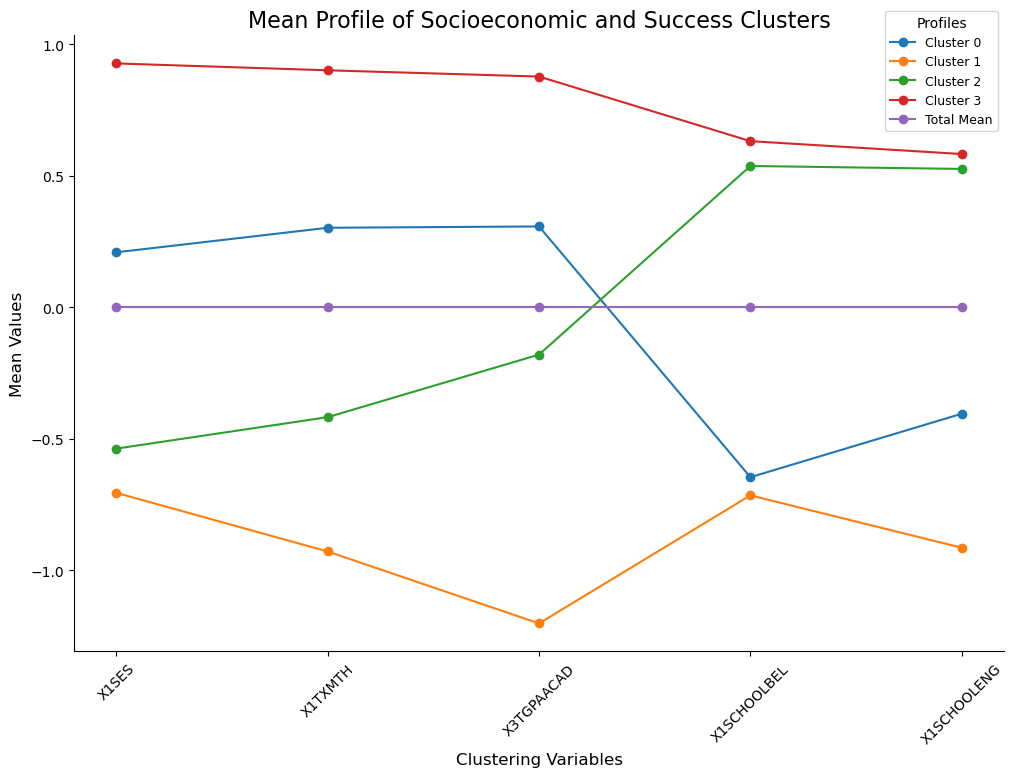

In [40]:
# Altered cluster analyses
hsls_cluster_z = hsls_cluster_z.drop(columns = ['QCL_1']).copy()

# Perform K-means clustering with predefined initial centroids
kmeans = KMeans(n_clusters=4, init='k-means++', n_init='auto', random_state=42)
hsls_cluster_z['QCL_1'] = kmeans.fit_predict(hsls_cluster_z)
hsls_cluster['Cluster'] = hsls_cluster_z['QCL_1']

# Final cluster centers (in standardized space)
final_centers = kmeans.cluster_centers_

# Create a DataFrame for easier inspection
final_centers_df = pd.DataFrame(final_centers, columns=continous_vars)
final_centers_transposed = final_centers_df.T

# Calculate cluster centers
cluster_centers = hsls_cluster_z.groupby("QCL_1")[continous_vars].mean()

# Calculate the total mean for all variables
total_mean = hsls_cluster_z[continous_vars].mean()

# Add the total mean as a new row labeled "Total"
cluster_centers.loc['Total'] = total_mean

# Transpose the cluster_centers DataFrame for easier plotting
cluster_centers_transposed = cluster_centers.T

# Create the plot
plt.figure(figsize=(12, 8))

# Plot each cluster's mean profile
for cluster in cluster_centers_transposed.columns:
    #if cluster != 'Total':
        plt.plot(
            cluster_centers_transposed.index,
            cluster_centers_transposed[cluster],
            marker='o',
            label=f"Cluster {cluster}" if cluster != 'Total' else 'Total Mean'
        )

# Customize the plot
plt.title("Mean Profile of Socioeconomic and Success Clusters", fontsize=16)
plt.xlabel("Clustering Variables", fontsize=12)
plt.ylabel("Mean Values", fontsize=12)
plt.xticks(fontsize=10, rotation=45)  # Rotate x-axis labels for better visibility
plt.legend(title="Profiles", fontsize=9, loc='upper right',
    bbox_to_anchor=(1, 1.05))  # Horizontal layout
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Display the plot
plt.show()

In [41]:
hsls_cluster['Cluster'].value_counts()

Cluster
2    4159
3    4097
0    3774
1    3330
Name: count, dtype: int64

In [42]:
# Display the ANOVA table
print("\nANOVA Table:")
ANOVA_On_Cluster(hsls_cluster, successVars, 4)


ANOVA Table:


,Variable,Cluster Mean Square,Cluster df,Error Mean Square,Error df,F,P_Val
0,X1TXMTH,2216.126003,3,0.481174,15356,4605.668795,0.0
1,X3TGPAACAD,2161.211508,3,0.344063,15356,6281.445395,0.0
2,X1SCHOOLBEL,1740.179204,3,0.513519,15356,3388.734741,0.0
3,X1SCHOOLENG,1727.590799,3,0.533903,15356,3235.775960,0.0


Another bunch of significant differences!

### Logistic Regression

#### Data Preprocessing

In [43]:
# Define variables of interest for this logistic regression
socioEconomicVars = ['X1SES', 'X1RACE', 'X1FAMINCOME', 'X1PAREDU']
academicVars = ['X3TGPAACAD']

# Declare narrower dataset for analysis
hsls_logit = hsls[socioEconomicVars + academicVars].copy()

In [44]:
# Create a binary variable for GPA ≥ 3.0. Over 3.0 is considered a success.
hsls_logit['X3GPACAT'] = (hsls_logit['X3TGPAACAD'] >= 3.0).astype(int)
hsls_logit = hsls_logit.drop(columns=['X3TGPAACAD'])

# Recode race variable to make caucasian the reference category. 0 is technically adopted, but there are none in our dataset.
## Need to make X1RACE an int so the replacement works and the dummies catch 0 as the first to drop
hsls_logit['X1RACE'] = hsls_logit['X1RACE'].astype(int) 
hsls_logit['X1RACE'] = hsls_logit['X1RACE'].replace({8: 0})

# One hot encode categorical variables and clean the decimals off column names
categoricalVars = ['X1RACE', 'X1FAMINCOME', 'X1PAREDU']
hsls_logit = pd.get_dummies(hsls_logit, columns=categoricalVars, drop_first=True)
hsls_logit.columns = hsls_logit.columns.str.replace('.0', '', regex=False)

dependentVar = 'X3GPACAT'
independentVars = [col for col in hsls_logit.columns if col != dependentVar]

#### Assumptions

**1. Binary Outcome**

In [45]:
# Show values counts for generated categorical variable
binaryOutcome = hsls_logit['X3GPACAT'].value_counts().sort_index().reset_index()
binaryOutcome['Percent_Whole'] = binaryOutcome['count']/sum(binaryOutcome['count'])
binaryOutcome

,X3GPACAT,count,Percent_Whole
0,0,7495,0.484173
1,1,7985,0.515827


As expected, fairly even amounts of 0s and 1s. 0 represents GPAs less than 3.0 and 1 represents GPAs of 3.0 of greater.

**2. Sample Size**

In [46]:
# Check the total number of observations
total_observations = hsls_logit.shape[0]
print(f"Total observations in the dataset: {total_observations}")

# Check to number of variables:
print(f"Technical total number of variables in the dataset: {len(independentVars)}")
print(f"Total number of variables in the dataset: {len(socioEconomicVars)}")

Total observations in the dataset: 15480
Technical total number of variables in the dataset: 25
Total number of variables in the dataset: 4


We have one hot encoded our categorical variables, so even though we only have 4 variables in our model (`X1SES`, `X1RACE`, `X1FAMINCOME`, and `X1PAREDU`) `X1RACE`, `X1FAMINCOME`, and `X1PAREDU` were expanded by category to make many binary variables that represent their one meaning. So, even though most analysts would consider a hot encoded variable as one, we technically have 25 variables! Luckily, we are using a very large dataset, so we have much more than 10x both counts for variable amounts (40 and 270). 

**3. Independence of Observations**

In [47]:
X = hsls_logit[independentVars]
y = hsls_logit[dependentVar]

In [48]:
# Calculate VIF for each predictor variable
vif_data = pd.DataFrame()
vif_data["Variable"] = independentVars
vif_data["VIF"] = [variance_inflation_factor(X.values.astype(int), i) for i in range(X.shape[1])]
vif_data["Tolerance"] = 1 / vif_data["VIF"]
vif_data.round(4)

,Variable,VIF,Tolerance
0,X1SES,2.0118,0.4971
1,X1RACE_1,1.0150,0.9852
2,X1RACE_2,1.1483,0.8708
3,X1RACE_3,1.1889,0.8411
4,X1RACE_4,1.0246,0.9760
5,X1RACE_5,1.2833,0.7792
6,X1RACE_6,1.1514,0.8685
7,X1RACE_7,1.0109,0.9892
8,X1FAMINCOME_2,2.4965,0.4006
9,X1FAMINCOME_3,2.6160,0.3823


The threshold for VIF is 5, and all variables have a VIF of less than 5! `X1PAREDU_2` is the closest variable in danger of breaking the threshold for VIF (with a value of 4.053422), but still stays below the threshold. This means we have nothing to remedy and this dataset's observations are independent.

**4. Linearity Between Predictors and Logits**

* A non-significant interaction indicates a linearity between the predictor variable and the logits.

In [49]:
# Create interaction terms for each predictor
interaction_terms = pd.DataFrame()

for predictor in ['X1SES']:
    interaction_terms[predictor + '_interaction'] = X[predictor] * np.log(X[predictor].replace(0, 0.01))

# Combine the original predictors with the interaction terms
X_interaction = pd.concat([X['X1SES'], interaction_terms], axis=1)

# Drop any rows with NaN values resulting from log(0)
X_interaction = X_interaction.dropna()
y = y[X_interaction.index]  # Align y with X_interaction

/Users/matthewduffy/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [50]:
# Fit the logistic regression model with interaction terms
model = sm.Logit(y, X_interaction).fit(maxiter=100, method='bfgs', cov_type='HC0')

# method='bfgs': The 'bfgs' (Broyden–Fletcher–Goldfarb–Shanno) algorithm is a quasi-Newton method
# often more robust to near-singularity than the default Newton-Raphson method.

# cov_type='HC0': This uses a heteroscedasticity-consistent covariance matrix estimator,
# which can be helpful when dealing with potential multicollinearity issues.


# Print the summary to check the significance of interaction terms
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.608789
         Iterations: 12
         Function evaluations: 13
         Gradient evaluations: 13
                           Logit Regression Results                           
Dep. Variable:               X3GPACAT   No. Observations:                 7879
Model:                          Logit   Df Residuals:                     7877
Method:                           MLE   Df Model:                            1
Date:                Tue, 05 Aug 2025   Pseudo R-squ.:                 0.04613
Time:                        03:51:28   Log-Likelihood:                -4796.7
converged:                       True   LL-Null:                       -5028.6
Covariance Type:                  HC0   LLR p-value:                6.705e-103
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
X1SES                 0.

We only tested our one continuous variable since categorical variables are inherently discrete (they cannot be linear). Based on the results from the test, `X1SES_interaction` **does not** have a significant interaction. That means we cannot reject the null hypothesis, so we can say that their is no significant evidence to support non-linearity (which means `X1SES` meets the assumption for linearity).

**Conclusion**

Our dataset meets all assumptions necessary for logistic regression!

#### Model

In [51]:
# Define model params and formula
formula = f"{dependentVar} ~ {' + '.join(independentVars)}"

# Define model and fit it
logit_model = smf.logit(formula, data=hsls_logit).fit(method='newton')

Optimization terminated successfully.
         Current function value: 0.603925
         Iterations 6


In [52]:
# Display model results
print(logit_model.summary())
coeffTable = logit_model.summary2().tables[1]

                           Logit Regression Results                           
Dep. Variable:               X3GPACAT   No. Observations:                15480
Model:                          Logit   Df Residuals:                    15454
Method:                           MLE   Df Model:                           25
Date:                Tue, 05 Aug 2025   Pseudo R-squ.:                  0.1281
Time:                        03:51:28   Log-Likelihood:                -9348.8
converged:                       True   LL-Null:                       -10722.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.3885      0.124     -3.141      0.002      -0.631      -0.146
X1RACE_1[T.True]          -0.9813      0.228     -4.313      0.000      -1.427      -0.535
X1RA

In [53]:
# Map variable meanings to the coefficient table
coeffTable['Variable'] = [meta.variable_value_labels[ind.replace('[T.True]', '').split('_')[0]][int(ind.replace('[T.True]', '').split('_')[1])] 
                                 if '_' in ind else 
                                 meta.column_names_to_labels[ind] 
                                 if ind not in ('Intercept', 'const') else 
                                 ''
                                 for ind in coeffTable.index
                                 ]

coeffTable = coeffTable[['Coef.', 'P>|z|', 'Variable']].round(6)
coeffTable['Odds Ratio'] = np.exp(coeffTable['Coef.'])
coeffTable['Change in Odds'] = (coeffTable['Odds Ratio'] - 1) * 100
coeffTable[['Variable', 'Coef.', 'P>|z|', 'Odds Ratio', 'Change in Odds']]

,Variable,Coef.,P>|z|,Odds Ratio,Change in Odds
Intercept,,-0.388512,0.001685,0.678065,-32.193491
X1RACE_1[T.True],"Amer. Indian/Alaska Native, non-Hispanic",-0.981330,0.000016,0.374812,-62.518773
X1RACE_2[T.True],"Asian, non-Hispanic",0.874024,0.000000,2.396535,139.653513
X1RACE_3[T.True],"Black/African-American, non-Hispanic",-0.925370,0.000000,0.396385,-60.361527
X1RACE_4[T.True],"Hispanic, no race specified",-0.556806,0.022487,0.573036,-42.696358
X1RACE_5[T.True],"Hispanic, race specified",-0.370326,0.000000,0.690509,-30.949081
X1RACE_6[T.True],"More than one race, non-Hispanic",-0.246205,0.000077,0.781762,-21.823805
X1RACE_7[T.True],"Native Hawaiian/Pacific Islander, non-Hispanic",-0.697198,0.005387,0.497979,-50.202131
X1FAMINCOME_2[T.True],"Family income > $15,000 and <= $35,000",-0.093938,0.226962,0.910339,-8.966080
X1FAMINCOME_3[T.True],"Family income > $35,000 and <= $55,000",0.098451,0.236587,1.103460,10.346033


##### Train Test Split Validation

In [54]:
# Use the formula and data already constructed
# dependentVar and independentVars are already defined above
# hsls_logit is the DataFrame to use

# Split data into train and test sets
train_df, test_df = train_test_split(hsls_logit, test_size=0.25, random_state=123456, stratify=hsls_logit[dependentVar])

# Fit logistic regression model on training data
logit_model_train = smf.logit(formula, data=train_df).fit(method='newton')

# Predict on test data
y_test = test_df[dependentVar]
y_pred_prob = logit_model_train.predict(test_df[independentVars])
y_pred = (y_pred_prob >= 0.5).astype(int)
print(logit_model_train.summary())

Optimization terminated successfully.
         Current function value: 0.604597
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               X3GPACAT   No. Observations:                11610
Model:                          Logit   Df Residuals:                    11584
Method:                           MLE   Df Model:                           25
Date:                Tue, 05 Aug 2025   Pseudo R-squ.:                  0.1271
Time:                        03:51:28   Log-Likelihood:                -7019.4
converged:                       True   LL-Null:                       -8041.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.4488      0.141     -3.178      0.001      -0.725      

In [55]:
# Map variable meanings to the coefficient table
coeffTable['Variable'] = [meta.variable_value_labels[ind.replace('[T.True]', '').split('_')[0]][int(ind.replace('[T.True]', '').split('_')[1])] 
                                 if '_' in ind else 
                                 meta.column_names_to_labels[ind] 
                                 if ind not in ('Intercept', 'const') else 
                                 ''
                                 for ind in coeffTable.index
                                 ]

coeffTable = coeffTable[['Coef.', 'P>|z|', 'Variable']].round(6)
coeffTable['Odds Ratio'] = np.exp(coeffTable['Coef.'])
coeffTable['Change in Odds'] = (coeffTable['Odds Ratio'] - 1) * 100
coeffTable[['Variable', 'Coef.', 'P>|z|', 'Odds Ratio', 'Change in Odds']]

,Variable,Coef.,P>|z|,Odds Ratio,Change in Odds
Intercept,,-0.388512,0.001685,0.678065,-32.193491
X1RACE_1[T.True],"Amer. Indian/Alaska Native, non-Hispanic",-0.981330,0.000016,0.374812,-62.518773
X1RACE_2[T.True],"Asian, non-Hispanic",0.874024,0.000000,2.396535,139.653513
X1RACE_3[T.True],"Black/African-American, non-Hispanic",-0.925370,0.000000,0.396385,-60.361527
X1RACE_4[T.True],"Hispanic, no race specified",-0.556806,0.022487,0.573036,-42.696358
X1RACE_5[T.True],"Hispanic, race specified",-0.370326,0.000000,0.690509,-30.949081
X1RACE_6[T.True],"More than one race, non-Hispanic",-0.246205,0.000077,0.781762,-21.823805
X1RACE_7[T.True],"Native Hawaiian/Pacific Islander, non-Hispanic",-0.697198,0.005387,0.497979,-50.202131
X1FAMINCOME_2[T.True],"Family income > $15,000 and <= $35,000",-0.093938,0.226962,0.910339,-8.966080
X1FAMINCOME_3[T.True],"Family income > $35,000 and <= $55,000",0.098451,0.236587,1.103460,10.346033


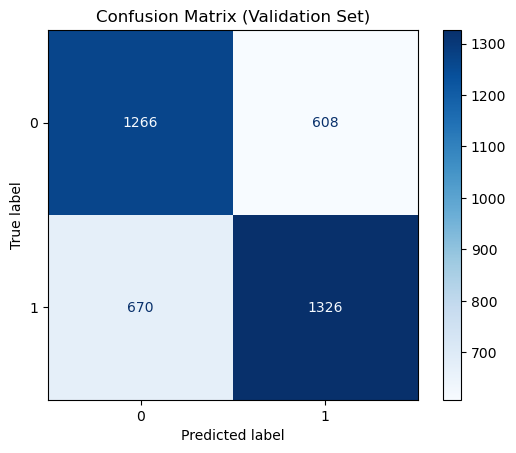

Accuracy:    0.670
Precision:   0.686
Recall:      0.664
Specificity: 0.676
F1 Score:    0.675


In [56]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix (Validation Set)')
plt.show()

# Calculate and print accuracy metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
specificity = recall_score(y_test, y_pred, pos_label=0)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy:    {accuracy:.3f}")
print(f"Precision:   {precision:.3f}")
print(f"Recall:      {recall:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"F1 Score:    {f1:.3f}")

#### Secondary Modelling

In [57]:
# Make a copy of the relavent DataFrame
hsls_extraLogit = hsls.copy()

# Define variables of interest for this logistic regression
socioEconomicVars = ['X1SES', 'X1RACE', 'X1FAMINCOME', 'X1PAREDU']
successVars = ['X1TXMTH', 'X1SCHOOLBEL', 'X1SCHOOLENG']
hsls_extraLogit = hsls_extraLogit[socioEconomicVars + successVars]

# Define null values that should be dropped

# Create a binary variable for Belonging ≥ mean. Greater than or equal to the mean is considered a success for these cases.
dependentVars = []
for var in successVars:
    hsls_extraLogit[var + 'CAT'] = (hsls_extraLogit[var] >= hsls_extraLogit[var].mean()).astype(int)
    hsls_extraLogit.drop(columns=var)
    dependentVars.append(var + 'CAT')

# Recode race variable to make caucasian the reference category. 0 is technically adopted, but there are none in our dataset.
hsls_extraLogit['X1RACE'] = hsls_extraLogit['X1RACE'].astype(int) 
hsls_extraLogit['X1RACE'] = hsls_extraLogit['X1RACE'].replace({8: 0})

# One hot encode categorical variables and clean the decimals off column names
categoricalVars = ['X1RACE', 'X1FAMINCOME', 'X1PAREDU']
hsls_extraLogit = pd.get_dummies(hsls_extraLogit, columns=categoricalVars, drop_first=True)
hsls_extraLogit.columns = hsls_extraLogit.columns.str.replace('.0', '', regex=False)

In [58]:
for var in dependentVars:
    display(hsls_extraLogit[var].value_counts().sort_index().reset_index())

,X1TXMTHCAT,count
0,0,7937
1,1,7543


,X1SCHOOLBELCAT,count
0,0,8051
1,1,7429


,X1SCHOOLENGCAT,count
0,0,6979
1,1,8501


In [59]:
# Define model params and formula
models = []
independentVars = [col for col in hsls_extraLogit.columns if col not in successVars + dependentVars]
for dep in dependentVars:
    extra_formula = f"{dep} ~ {' + '.join(independentVars)}"
    extra_logit_model = smf.logit(extra_formula, data=hsls_extraLogit).fit(method='newton')
    models.append(extra_logit_model)

Optimization terminated successfully.
         Current function value: 0.613928
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.680980
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.677815
         Iterations 4


In [60]:
for model, dep in zip(models, dependentVars):
    print(f"\nModel Summary for {dep}:")
    print(model.summary())
    coeffTable = model.summary2().tables[1]
        
    # Display the coefficient table and map variable meanings to the coefficient table
    coeffTable['Variable'] = [meta.variable_value_labels[ind.replace('[T.True]', '').split('_')[0]][int(ind.replace('[T.True]', '').split('_')[1])] 
                                    if '_' in ind else 
                                    meta.column_names_to_labels[ind] 
                                    if ind not in ('Intercept', 'const') else 
                                    ''
                                    for ind in coeffTable.index
                                    ]

    coeffTable = coeffTable[['Coef.', 'P>|z|', 'Variable']].round(6)
    coeffTable['Odds Ratio'] = np.exp(coeffTable['Coef.'])
    coeffTable['Change in Odds'] = (coeffTable['Odds Ratio'] - 1) * 100
    coeffTable[['Variable', 'Coef.', 'P>|z|', 'Odds Ratio', 'Change in Odds']]
    print("\n")
    display(coeffTable.round(6))
    html_table = model.summary().tables[0].as_html()
    with open(f"logit_summary_table{dep}.html", "w") as f:
        f.write(html_table) 
    coeffTable[['Variable', 'Coef.', 'P>|z|', 'Odds Ratio', 'Change in Odds']].round(6).to_html(f'table{dep}.html', index=False)


Model Summary for X1TXMTHCAT:
                           Logit Regression Results                           
Dep. Variable:             X1TXMTHCAT   No. Observations:                15480
Model:                          Logit   Df Residuals:                    15454
Method:                           MLE   Df Model:                           25
Date:                Tue, 05 Aug 2025   Pseudo R-squ.:                  0.1139
Time:                        03:51:29   Log-Likelihood:                -9503.6
converged:                       True   LL-Null:                       -10725.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.7363      0.125     -5.883      0.000      -0.982      -0.491
X1RACE_1[T.True]          -0.5837      0.218     -2.676      0.0

,Coef.,P>|z|,Variable,Odds Ratio,Change in Odds
Intercept,-0.736333,0.000000,,0.478867,-52.113330
X1RACE_1[T.True],-0.583747,0.007456,"Amer. Indian/Alaska Native, non-Hispanic",0.557804,-44.219565
X1RACE_2[T.True],1.029402,0.000000,"Asian, non-Hispanic",2.799391,179.939130
X1RACE_3[T.True],-0.756284,0.000000,"Black/African-American, non-Hispanic",0.469408,-53.059249
X1RACE_4[T.True],-0.655555,0.013197,"Hispanic, no race specified",0.519154,-48.084615
X1RACE_5[T.True],-0.219526,0.000035,"Hispanic, race specified",0.802899,-19.710072
X1RACE_6[T.True],0.005301,0.931662,"More than one race, non-Hispanic",1.005315,0.531508
X1RACE_7[T.True],-0.079550,0.740895,"Native Hawaiian/Pacific Islander, non-Hispanic",0.923532,-7.646816
X1FAMINCOME_2[T.True],-0.058307,0.460127,"Family income > $15,000 and <= $35,000",0.943360,-5.663971
X1FAMINCOME_3[T.True],0.184151,0.028078,"Family income > $35,000 and <= $55,000",1.202197,20.219734



Model Summary for X1SCHOOLBELCAT:
                           Logit Regression Results                           
Dep. Variable:         X1SCHOOLBELCAT   No. Observations:                15480
Model:                          Logit   Df Residuals:                    15454
Method:                           MLE   Df Model:                           25
Date:                Tue, 05 Aug 2025   Pseudo R-squ.:                 0.01641
Time:                        03:51:29   Log-Likelihood:                -10542.
converged:                       True   LL-Null:                       -10717.
Covariance Type:            nonrobust   LLR p-value:                 2.195e-59
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 -0.3407      0.111     -3.070      0.002      -0.558      -0.123
X1RACE_1[T.True]          -0.0431      0.195     -0.221     

,Coef.,P>|z|,Variable,Odds Ratio,Change in Odds
Intercept,-0.340721,0.002139,,0.711257,-28.874268
X1RACE_1[T.True],-0.043077,0.825481,"Amer. Indian/Alaska Native, non-Hispanic",0.957838,-4.216237
X1RACE_2[T.True],0.157017,0.014363,"Asian, non-Hispanic",1.170016,17.001550
X1RACE_3[T.True],0.159186,0.006088,"Black/African-American, non-Hispanic",1.172556,17.255602
X1RACE_4[T.True],-0.049357,0.813891,"Hispanic, no race specified",0.951841,-4.815874
X1RACE_5[T.True],0.017954,0.719440,"Hispanic, race specified",1.018116,1.811614
X1RACE_6[T.True],-0.082362,0.166332,"More than one race, non-Hispanic",0.920939,-7.906148
X1RACE_7[T.True],-0.286205,0.226202,"Native Hawaiian/Pacific Islander, non-Hispanic",0.751109,-24.889138
X1FAMINCOME_2[T.True],-0.105580,0.131185,"Family income > $15,000 and <= $35,000",0.899802,-10.019751
X1FAMINCOME_3[T.True],-0.042389,0.578944,"Family income > $35,000 and <= $55,000",0.958497,-4.150315



Model Summary for X1SCHOOLENGCAT:
                           Logit Regression Results                           
Dep. Variable:         X1SCHOOLENGCAT   No. Observations:                15480
Model:                          Logit   Df Residuals:                    15454
Method:                           MLE   Df Model:                           25
Date:                Tue, 05 Aug 2025   Pseudo R-squ.:                 0.01524
Time:                        03:51:29   Log-Likelihood:                -10493.
converged:                       True   LL-Null:                       -10655.
Covariance Type:            nonrobust   LLR p-value:                 6.130e-54
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0215      0.110      0.195      0.846      -0.195       0.238
X1RACE_1[T.True]          -0.6284      0.199     -3.162     

,Coef.,P>|z|,Variable,Odds Ratio,Change in Odds
Intercept,0.021508,0.845648,,1.021741,2.174096
X1RACE_1[T.True],-0.628413,0.001570,"Amer. Indian/Alaska Native, non-Hispanic",0.533438,-46.656230
X1RACE_2[T.True],0.411480,0.000000,"Asian, non-Hispanic",1.509050,50.904953
X1RACE_3[T.True],-0.146408,0.011353,"Black/African-American, non-Hispanic",0.863805,-13.619480
X1RACE_4[T.True],-0.193672,0.347241,"Hispanic, no race specified",0.823928,-17.607189
X1RACE_5[T.True],-0.145433,0.003409,"Hispanic, race specified",0.864648,-13.535218
X1RACE_6[T.True],-0.114245,0.053386,"More than one race, non-Hispanic",0.892039,-10.796062
X1RACE_7[T.True],0.058281,0.801698,"Native Hawaiian/Pacific Islander, non-Hispanic",1.060013,6.001282
X1FAMINCOME_2[T.True],-0.209176,0.002546,"Family income > $15,000 and <= $35,000",0.811252,-18.874756
X1FAMINCOME_3[T.True],-0.108949,0.151792,"Family income > $35,000 and <= $55,000",0.896776,-10.322385
